In [11]:
# for bjorkeny estimation

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor as RFR
# from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from scipy.stats import randint
import matplotlib.pyplot as plt
# import seaborn as sns

from collections import Counter
# import os
from sklearn import preprocessing
from sklearn.decomposition import PCA
from functions import *
import keras
import pickle


2024-06-20 15:55:58.104602: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 15:55:59.297045: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Initial Data


jmuon_JSHOWERFIT_ENERGY                0.09
jmuon_E                                0.09
jmuon_JENERGY_ENERGY                   0.09
jmuon_JENERGY_MAXIMAL_ENERGY           0.09
jmuon_JENERGY_MINIMAL_ENERGY           0.08
jmuon_JENERGY_MUON_RANGE_METRES        0.08
jmuon_JENERGY_CHI2                     0.06
jmuon_JENERGY_NDF                      0.05
jmuon_JSTART_NPE_MIP                   0.05
jmuon_JGANDALF_CHI2                    0.04
jmuon_JGANDALF_NUMBER_OF_ITERATIONS    0.04
jmuon_dir_x                            0.04
jmuon_JGANDALF_NUMBER_OF_HITS          0.03
jmuon_t                                0.03
jmuon_JENERGY_NUMBER_OF_HITS           0.02
jmuon_JSTART_NPE_MIP_TOTAL             0.01
jmuon_dir_y                            0.01
jmuon_pos_x                            0.01
jmuon_JGANDALF_LAMBDA                  0.01
jmuon_pos_y                            0.00
jmuon_pos_z                           -0.00
jmuon_JSTART_LENGTH_METRES            -0.01
jmuon_dir_z                     

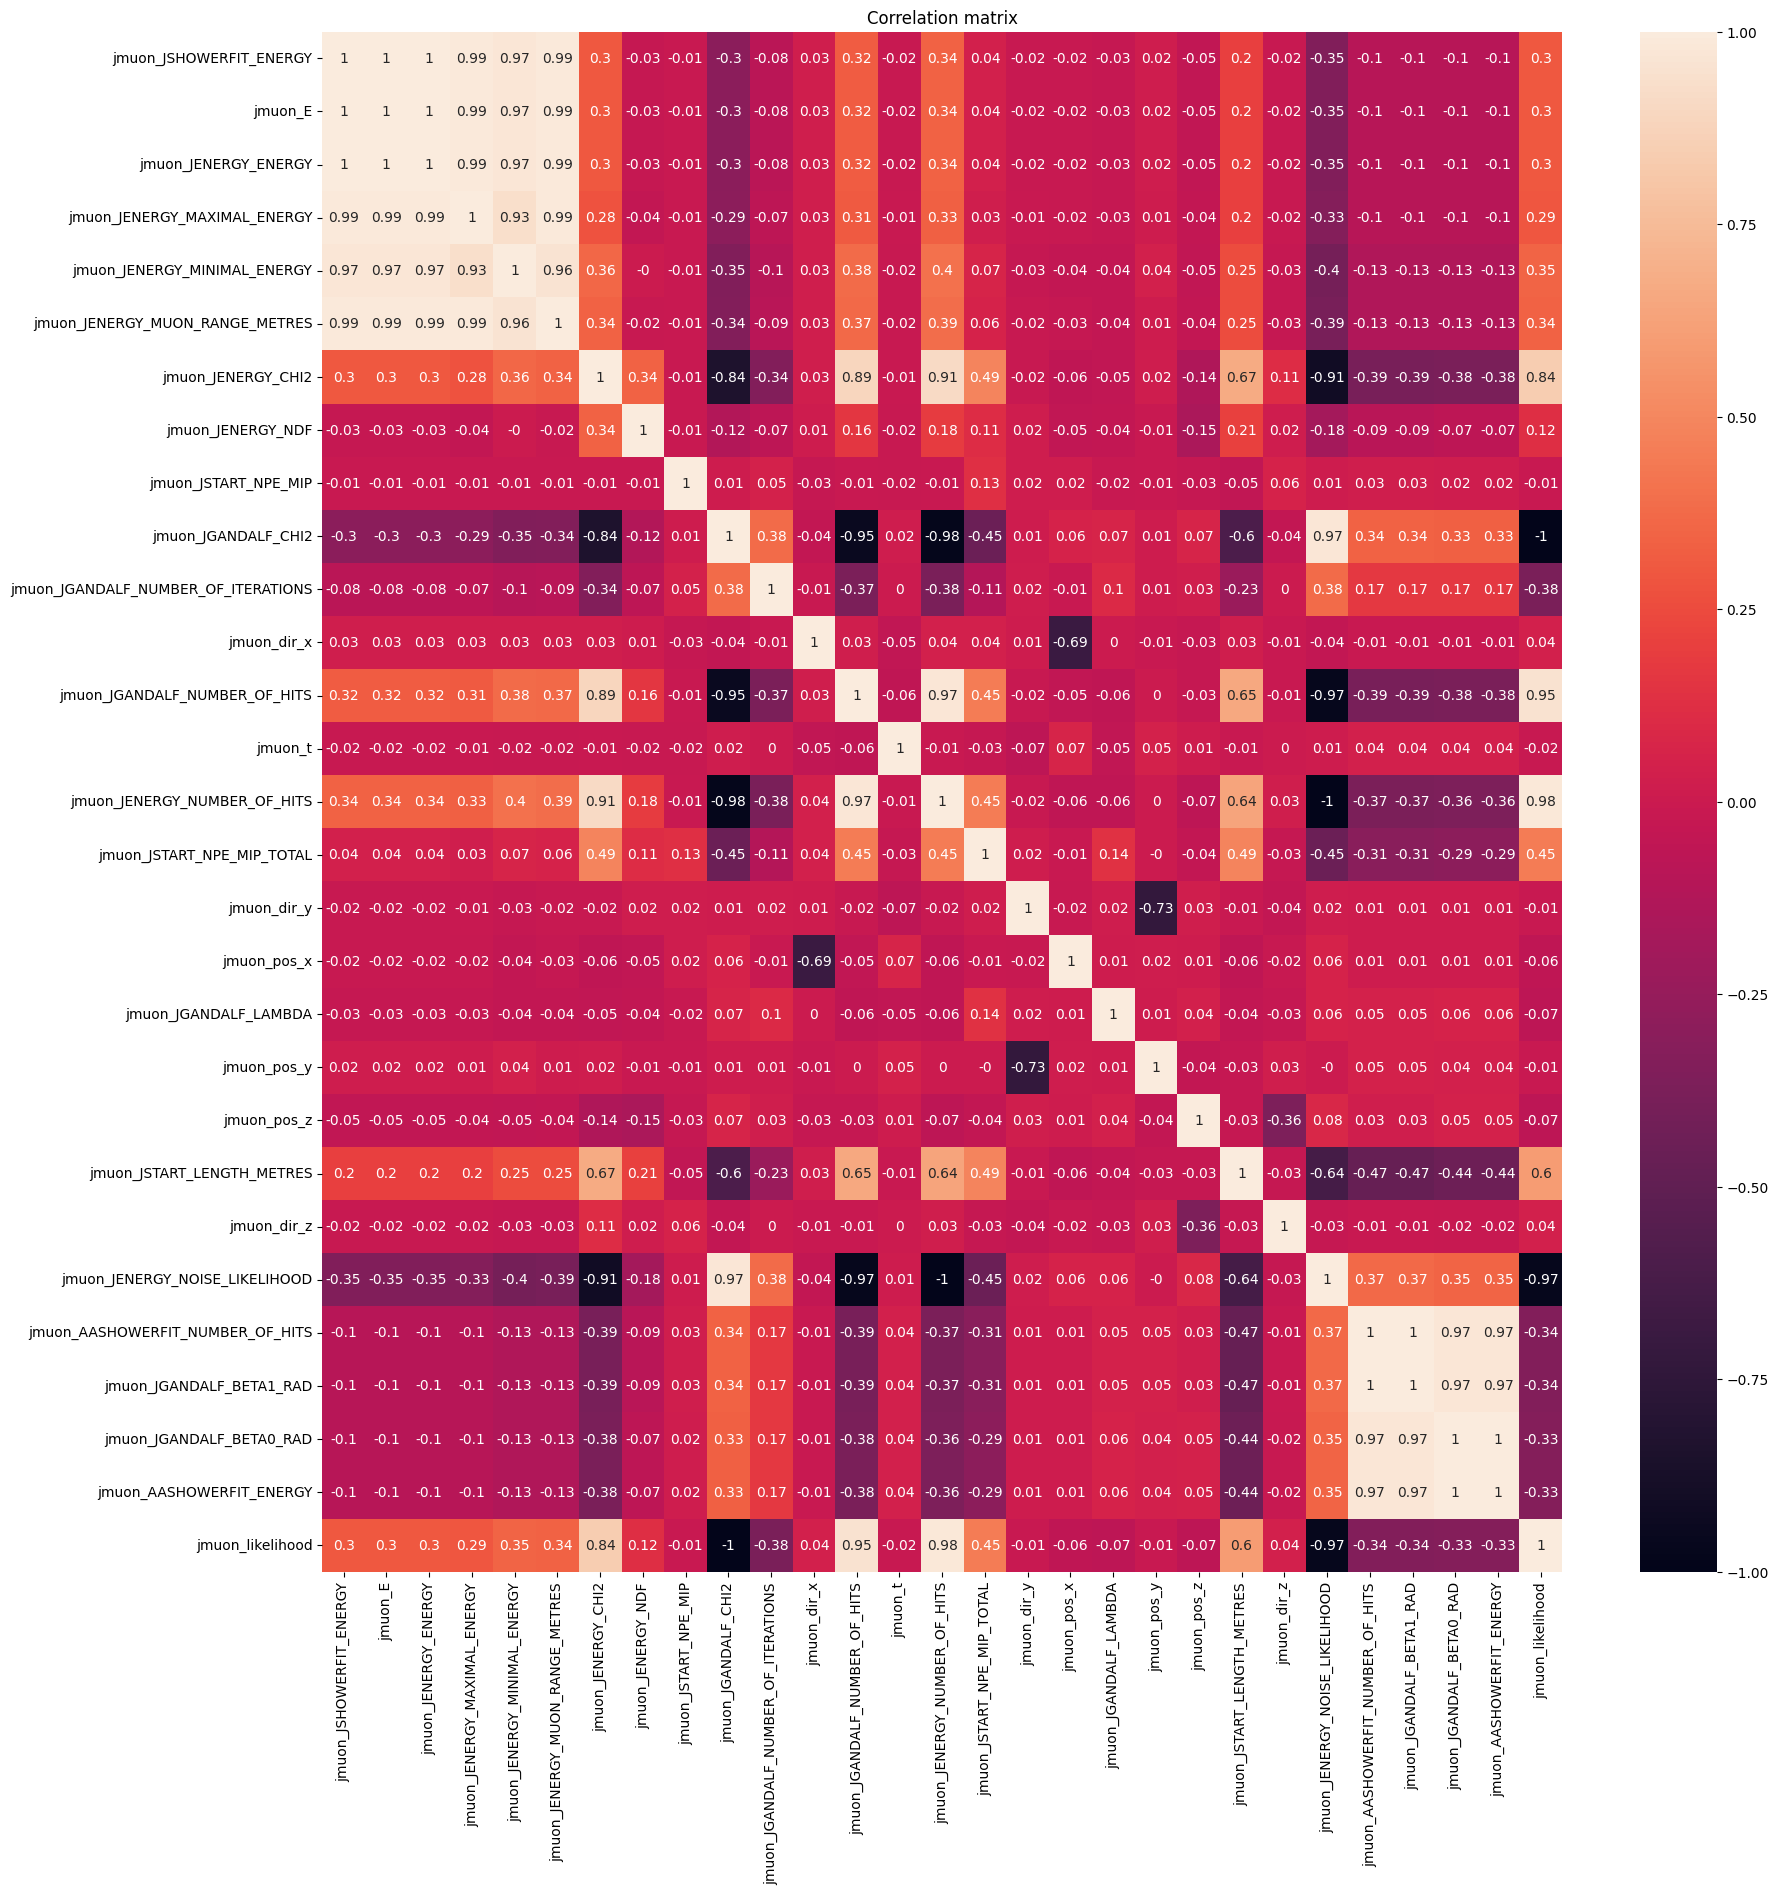

1321
Index(['jmuon_JSHOWERFIT_ENERGY', 'jmuon_E', 'jmuon_JENERGY_ENERGY',
       'jmuon_JENERGY_MAXIMAL_ENERGY', 'jmuon_JENERGY_MINIMAL_ENERGY',
       'jmuon_JENERGY_MUON_RANGE_METRES', 'jmuon_JENERGY_CHI2',
       'jmuon_JENERGY_NDF', 'jmuon_JSTART_NPE_MIP', 'jmuon_JGANDALF_CHI2',
       'jmuon_JGANDALF_NUMBER_OF_ITERATIONS', 'jmuon_dir_x',
       'jmuon_JGANDALF_NUMBER_OF_HITS', 'jmuon_t',
       'jmuon_JENERGY_NUMBER_OF_HITS', 'jmuon_JSTART_NPE_MIP_TOTAL',
       'jmuon_dir_y', 'jmuon_pos_x', 'jmuon_JGANDALF_LAMBDA', 'jmuon_pos_y',
       'jmuon_pos_z', 'jmuon_JSTART_LENGTH_METRES', 'jmuon_dir_z',
       'jmuon_JENERGY_NOISE_LIKELIHOOD', 'jmuon_AASHOWERFIT_NUMBER_OF_HITS',
       'jmuon_JGANDALF_BETA1_RAD', 'jmuon_JGANDALF_BETA0_RAD',
       'jmuon_AASHOWERFIT_ENERGY', 'jmuon_likelihood'],
      dtype='object')


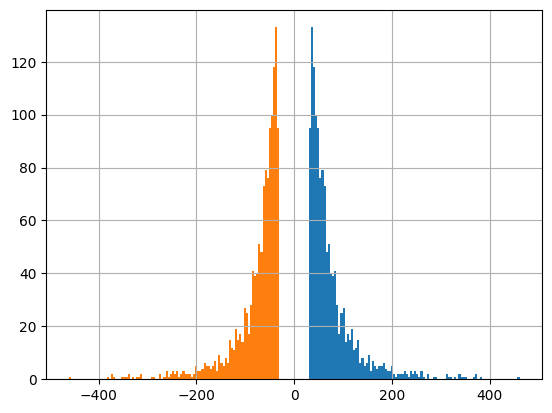

In [3]:
# neutr_paths = os.listdir("datav2")
# muon_path = "datav2/"+neutr_paths.pop(-2)

# for i, path in enumerate(neutr_paths):
#     neutr_paths[i] = "datav2/"+path
# neutr_types = ["neutrino_elec-CC","neutrino_muon-NC","neutrino_tau-CC","neutrino_anti-elec-CC","neutrino_anti-muon-CC","neutrino_anti-tau-CC","neutrino_muon-CC","neutrino_anti-muon-NC"]

# load data
# df_muon = load_muon_data(muon_path)
# df_neutr = load_neutrino_data(neutr_paths, neutr_types)


# df = df_neutr
df = pd.read_hdf("datav2/data_muon-CC_shuffled_dl.h5", key = 'y')

# print(df.columns)

# try a cut
df = df[df['jmuon_likelihood']>30]
pos_frac = 0.0
min_x = np.min(df['jmuon_pos_x'])
max_x = np.max(df["jmuon_pos_x"])
x_diff = max_x - min_x
min_y = np.min(df['jmuon_pos_y'])
max_y = np.max(df["jmuon_pos_y"])
y_diff = max_y - min_y
df = df[np.all([df['jmuon_pos_x'] > min_x+pos_frac*x_diff, df['jmuon_pos_x'] < max_x-pos_frac*x_diff, df['jmuon_pos_y'] > min_y+pos_frac*y_diff, df['jmuon_pos_y'] < max_y-pos_frac*y_diff], axis = 0)]


#
df = remove_nans(df)
df = df.drop(columns = [column for column in df.columns if len(df[column].unique()) == 1])
df = df.drop(columns = "jmuon_group_id")
corr = correlation_matrix(df, figsize = (20,20), plot = False)

# select only relevant features
reco_columns = [column for column in df.columns if column[:5] == "jmuon"]


bjorkeny_corr = corr['bjorkeny'][reco_columns]
# bjorkeny_corr = bjorkeny_corr[bjorkeny_corr!=0]
# bjorkeny_corr = bjorkeny_corr[b]
bjorkeny_corr = bjorkeny_corr.sort_values(ascending = False)
print(bjorkeny_corr)



# Simulation data

X = df[bjorkeny_corr.index]
corr = correlation_matrix(X, figsize = (20,20), plot = True)
hist = X['jmuon_likelihood'].hist(bins = 100)
hist = X['jmuon_JGANDALF_CHI2'].hist(bins=100)
# X = X.drop(columns=["jmuon_group_id"])
y = df.drop(columns=reco_columns)

scaler = preprocessing.StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
print(len(y))
print(X.columns)


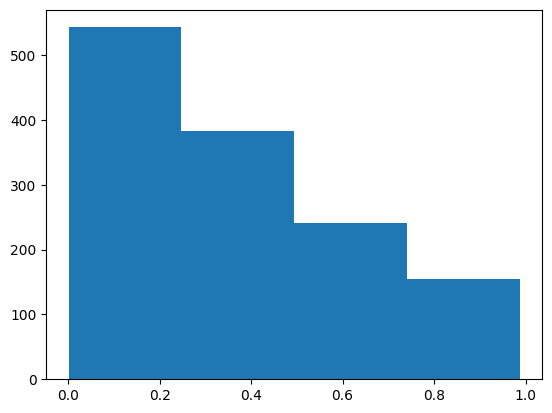

In [4]:
plt.figure()
plt.hist(y['bjorkeny'], bins=4)
plt.show()

In [5]:
DNN = tf.keras.Sequential()
DNN.add(tf.keras.layers.Input(shape=(X.shape[1],)))
# DNN.add(tf.keras.layers.Dense(64, activation="relu"))
DNN.add(tf.keras.layers.Dense(64, activation="relu"))
DNN.add(keras.layers.Dropout(0.2))
DNN.add(tf.keras.layers.Dense(64, activation="relu"))
DNN.add(keras.layers.Dropout(0.2))
# DNN.add(tf.keras.layers.Dense(32, activation="relu"))
DNN.add(tf.keras.layers.Dense(64, activation="relu"))
DNN.add(keras.layers.Dropout(0.2))
DNN.add(tf.keras.layers.Dense(64, activation="relu"))
DNN.add(keras.layers.Dropout(0.2))
DNN.add(tf.keras.layers.Dense(64, activation="relu"))
DNN.add(keras.layers.Dropout(0.2))
DNN.add(tf.keras.layers.Dense(64, activation="relu"))
DNN.add(keras.layers.Dropout(0.2))
DNN.add(tf.keras.layers.Dense(64, activation="relu"))
DNN.add(keras.layers.Dropout(0.2))
DNN.add(tf.keras.layers.Dense(64, activation="relu"))
DNN.add(keras.layers.Dropout(0.2))
DNN.add(tf.keras.layers.Dense(1, activation='sigmoid' ))
# DNN.add(tf.keras.layers.Dense(, activation="relu"))
# DNN.add(tf.keras.layers.Dense(64, activation="relu"))


DNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="mse")
DNN.summary()

2024-06-10 15:21:14.580560: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 15:21:14.582407: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,105 (121.50 KB)

 Trainable params: 31,105 (121.50 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# n_its = 20
# random_states = np.arange(n_its)
# MSE = []
# # df_prediction_difficulties = pd.DataFrame()

# for random_state in random_states:
    
X_train, X_test, y_train, y_test = train_test_split(X, y , shuffle = True, test_size=0.2, random_state=42)
train_bjorkeny = y_train['bjorkeny']
y_test = y_test['bjorkeny'].to_numpy().reshape(-1,1)
train_bjorkeny = train_bjorkeny.to_numpy().reshape(-1,1)


# print(train_bjorkeny[:10])


# specific_types_test = y_test['type']
# specific_types_train = X_train_full['type']
history = DNN.fit(X_train, train_bjorkeny, epochs=1000, batch_size=32, validation_split=0.15, verbose=1)

Epoch 1/1000


KeyboardInterrupt: 

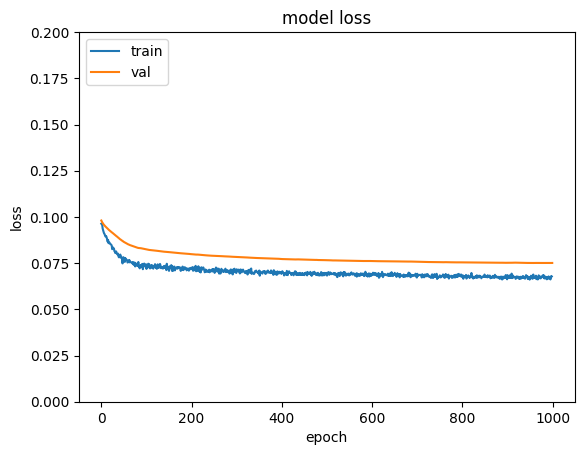

In [ ]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.ylim(0,0.2)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Text(0, 0.5, 'Fraction of events')

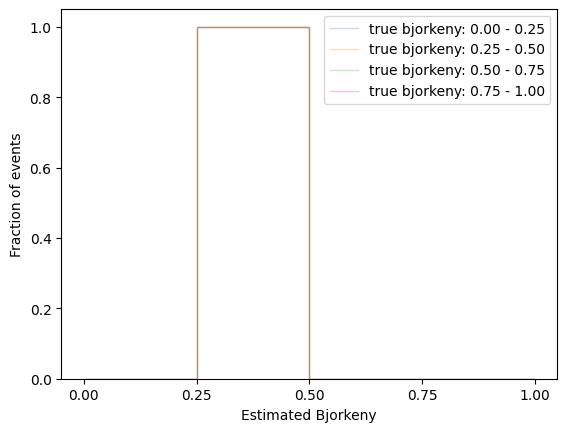

In [ ]:

y_pred_total = DNN.predict(X_test)
x_axis = np.linspace(0,1,5)

true_bjorkeny_1_mask = y_test <= 0.25
est_bjorkeny_1_mask = y_pred_total <= 0.25

true_bjorkeny_2_mask = (y_test <= 0.5) & (y_test > 0.25)
est_bjorkeny_2_mask = (y_pred_total <= 0.5) & (y_pred_total > 0.25)

true_bjorkeny_3_mask = (y_test <= 0.75) & (y_test > 0.5)
est_bjorkeny_3_mask = (y_pred_total <= 0.75) & (y_pred_total > 0.5)

true_bjorkeny_4_mask = (y_test <= 1) & (y_test > 0.75)
est_bjorkeny_4_mask = (y_pred_total <= 1) & (y_pred_total > 0.75)

true_segments = [true_bjorkeny_1_mask, true_bjorkeny_2_mask, true_bjorkeny_3_mask, true_bjorkeny_4_mask]
est_segments = [est_bjorkeny_1_mask, est_bjorkeny_2_mask, est_bjorkeny_3_mask, est_bjorkeny_4_mask]

fig, ax = plt.subplots()
for i, segment in enumerate(true_segments):
    frac = np.sum(segment&est_segments[i])/np.sum(segment)
    fractions = [(np.sum(segment & est_segment))/np.sum(segment) for est_segment in est_segments]
    ax.stairs(fractions, x_axis, alpha = 0.25, fill = False, label = f"true bjorkeny: {x_axis[i]:.2f} - {x_axis[i+1]:.2f}")

ax.set_xticks(x_axis)
ax.legend()
ax.set_xlabel("Estimated Bjorkeny")
ax.set_ylabel("Fraction of events")


# New Data Analysis


In [2]:
df_11 = pd.read_hdf("datay/new_neutrino11x_1.h5")
df_12 = pd.read_hdf("datay/new_neutrino12x_1.h5")
df_13 = pd.read_hdf("datay/new_neutrino13x_1.h5")

df = pd.concat([df_11, df_12, df_13])

df = remove_nans(df, 0.1)
#exposure: ignore for now
# weight: ignore for now

# weight_rate: ignore for now


print(df["pdgid"].value_counts())
print(df["is_cc"].value_counts())
# df = df[df["E.trks.rec_type[:,1]"]==4000]
df = df[(df["pdgid"]==14)&(df["is_cc"]==1)]
df = df[(df["E.trks.E[:,0]"]<=20) | (df["E.trks.E[:,1]"]<=20)]
# df = df[df["energy"]<=20]
df = df[np.invert((df['closest[:,0,0]']==1e20) | (df['closest[:,1,0]']==1e20) | (df['closest[:,1,2]']==1e20) | (df['closest[:,0,1]']==1e20)  )] 
print(df.info())
# original_counts = df["pdgid"].value_counts()
# print(df["pdgid"].value_counts())



pdgid
 14    820483
-14    422868
 12    276128
-12    175701
 16     52425
-16     46541
Name: count, dtype: int64
is_cc
1.0    1328344
0.0     465802
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 137253 entries, 1100 to 235589
Data columns (total 64 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   E.run_id                                              137253 non-null  int32  
 1   exposure                                              137253 non-null  float32
 2   weight                                                137253 non-null  float64
 3   weight_rate                                           137253 non-null  float64
 4   angle_shfit_gandalf                                   137253 non-null  float64
 5   closest[:,0,0]                                        137253 non-null  float64
 6   closest[:,0,1]                      

In [7]:
print(df["weight"][:10])
print(df["weight_rate"][:10])
print(df["exposure"][:10])

1100    0.015539
1103    0.013992
1116    0.012177
1117    0.013847
1135    0.013653
1138    0.012278
1143    0.011412
1147    0.015877
1158    0.009353
1160    0.011051
Name: weight, dtype: float64
1100    6.489797e-09
1103    5.843786e-09
1116    5.085816e-09
1117    5.783233e-09
1135    5.702174e-09
1138    5.127689e-09
1143    4.766246e-09
1147    6.631042e-09
1158    3.906267e-09
1160    4.615586e-09
Name: weight_rate, dtype: float64
1100    2394371.75
1103    2394371.75
1116    2394371.75
1117    2394371.75
1135    2394371.75
1138    2394371.75
1143    2394371.75
1147    2394371.75
1158    2394371.75
1160    2394371.75
Name: exposure, dtype: float32


## check reco energy vs true

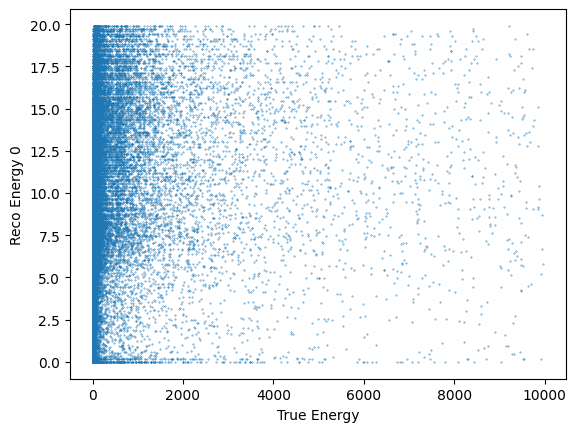

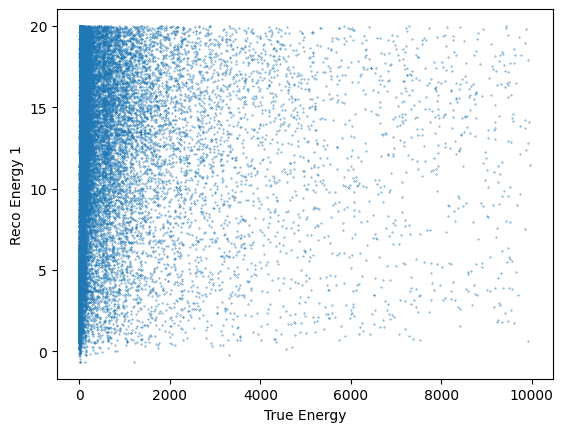

In [3]:
true_energy = df['energy']
true_bjorkeny = df['T.sum_mc_nu.by']
reco_E0 = df['E.trks.E[:,0]']
reco_E1 = df['E.trks.E[:,1]']

plt.scatter(true_energy, reco_E0, s = 0.1)
plt.xlabel("True Energy")
plt.ylabel("Reco Energy 0")
plt.show()

plt.scatter(true_energy, reco_E1, s = 0.1)
plt.xlabel("True Energy")
plt.ylabel("Reco Energy 1")
plt.show()

## check distributions

0
0


/home/jbosman/NIKHEF/nhml/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


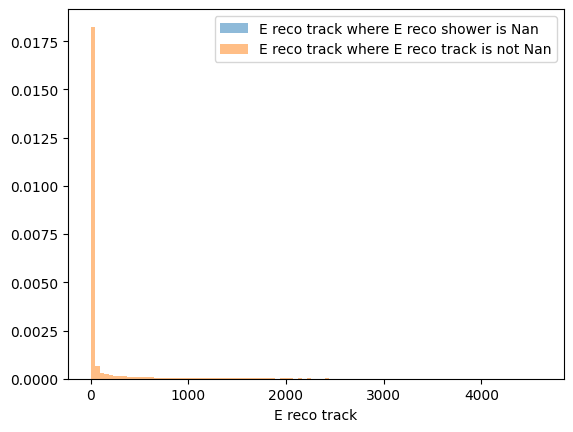

In [147]:
print(df["E.trks.E[:,0]"].isna().sum())
print(df["E.trks.E[:,1]"].isna().sum())

plt.hist(df[(df["E.trks.E[:,1]"].isna())]["E.trks.E[:,0]"], bins = 100, range = (0,np.quantile(df["E.trks.E[:,0]"],0.99)), alpha = 0.5, density = True, label = "E reco track where E reco shower is Nan")
plt.hist(df[np.invert(df["E.trks.E[:,1]"].isna())]["E.trks.E[:,0]"], bins = 100, range = (0,np.quantile(df["E.trks.E[:,0]"],0.99)), alpha = 0.5, density = True, label = "E reco track where E reco track is not Nan")
plt.legend()
plt.xlabel("E reco track")
plt.show()

In [43]:
column = "dist_JG_Jsh_track"

hist = df[df[column].isna()]["T.sum_mc_nu.by"].hist(bins = 100, alpha = 0.5, density = True, label = "dist_JG_Jsh_track is Nan")
hist = df[np.invert(df[column].isna())]["T.sum_mc_nu.by"].hist(bins = 100, alpha = 0.5, density = True, label = "dist_JG_Jsh_track is not Nan")

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f2dfad849d0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


KeyError: 'dist_JG_Jsh_track'

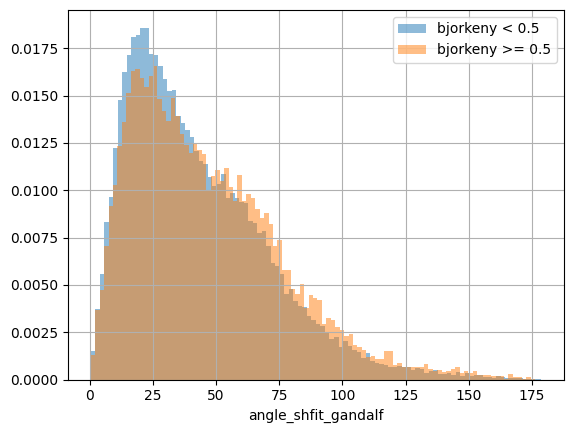

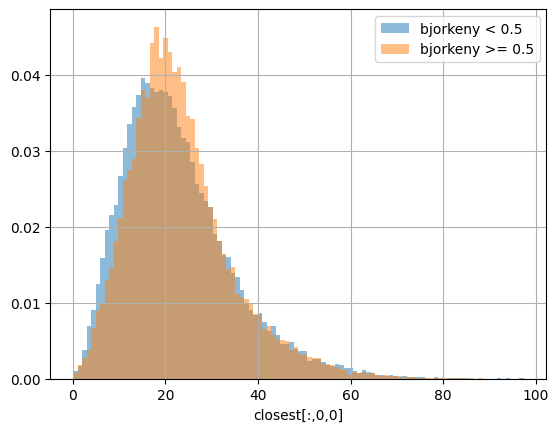

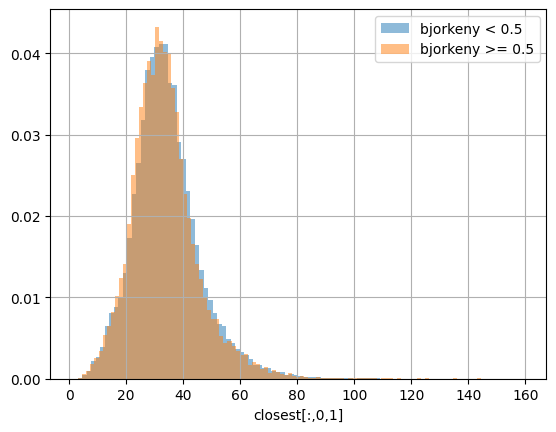

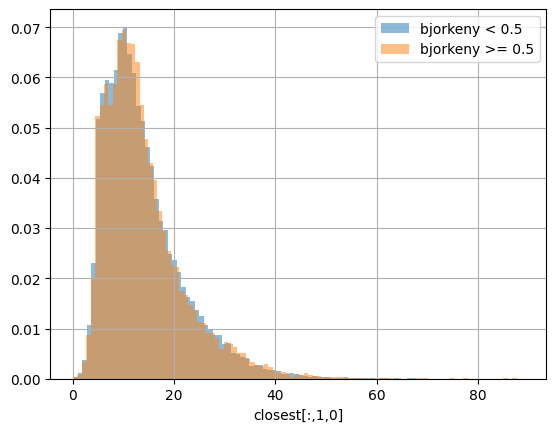

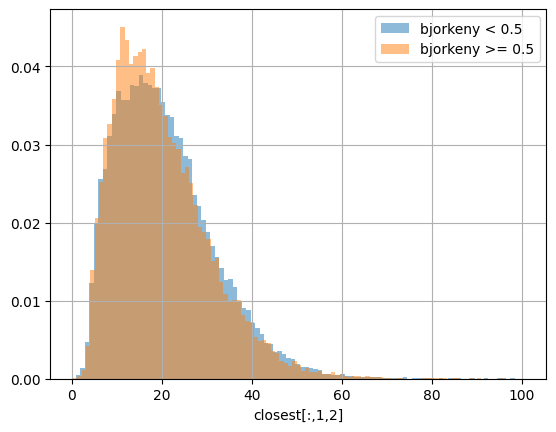

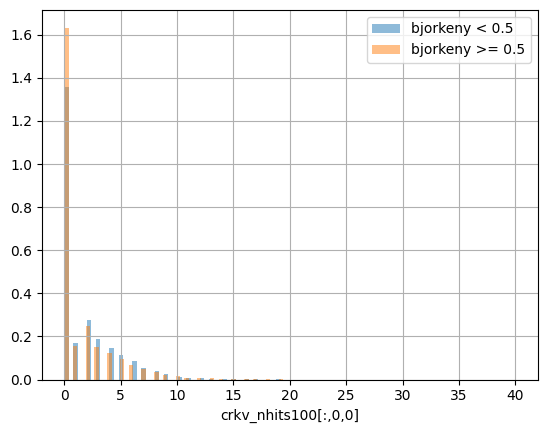

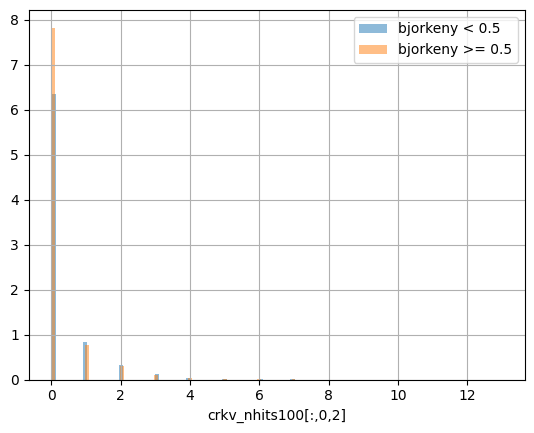

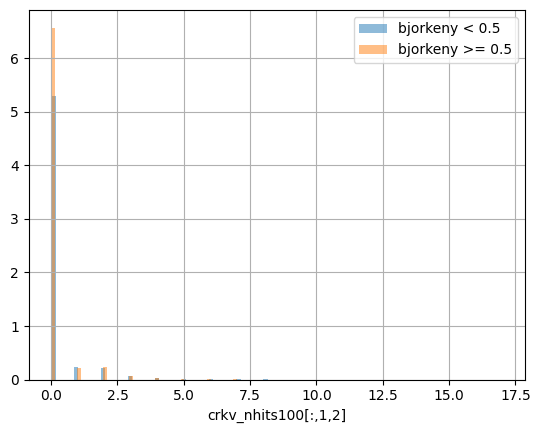

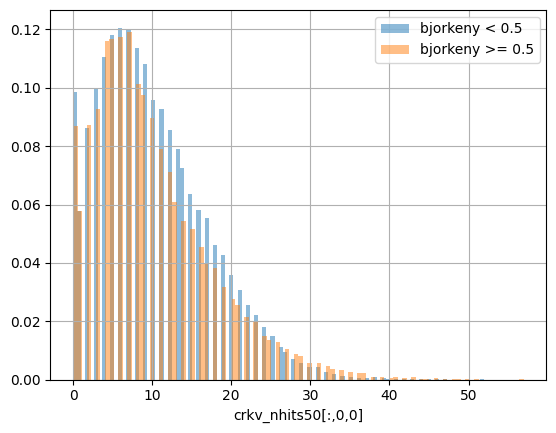

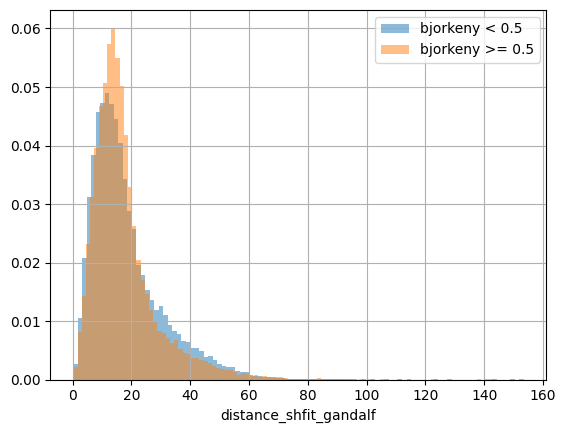

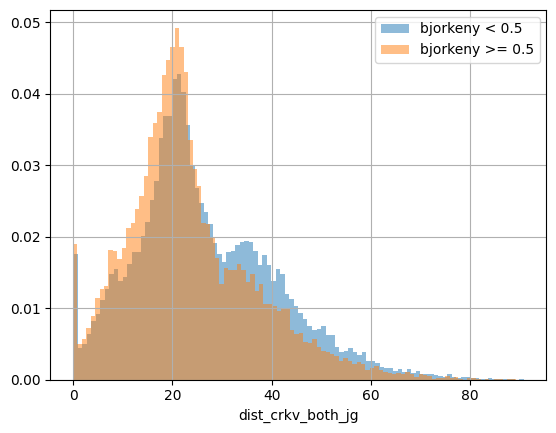

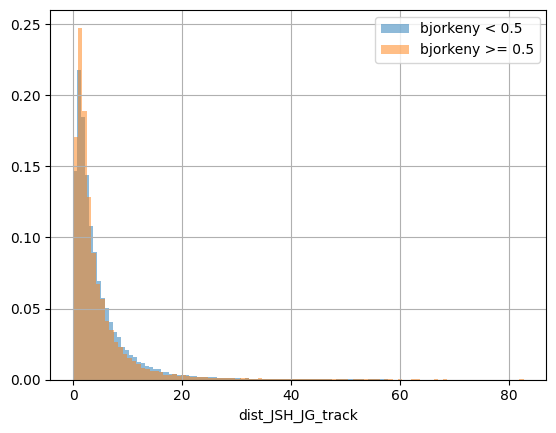

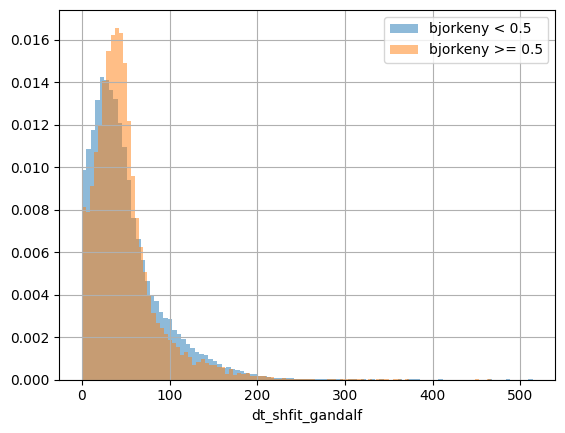

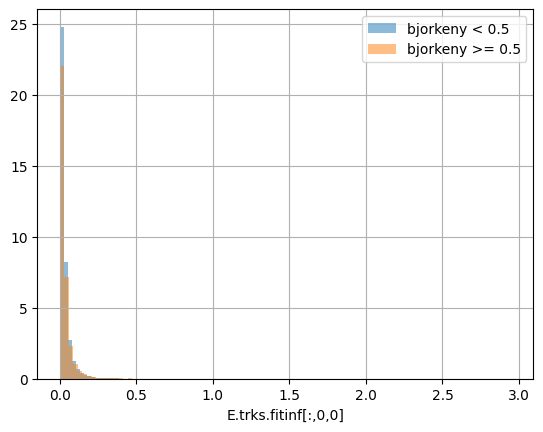

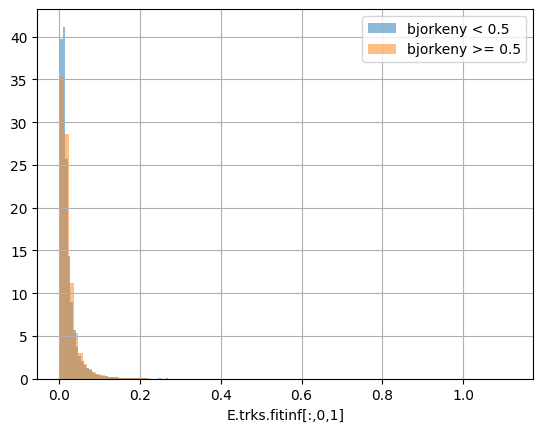

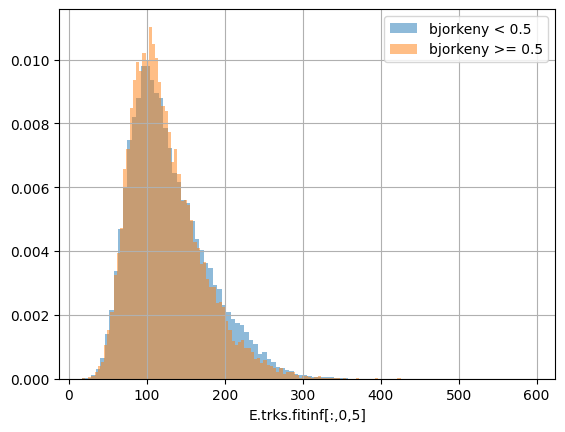

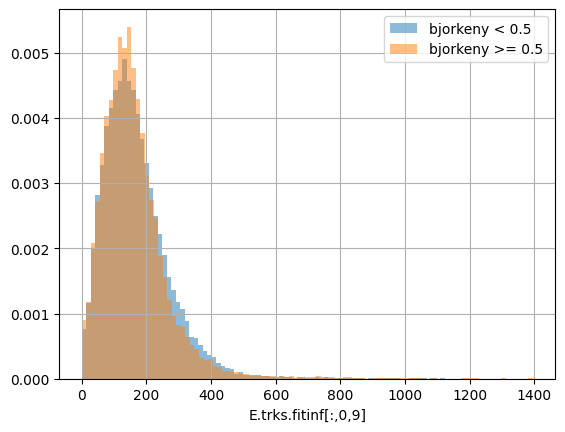

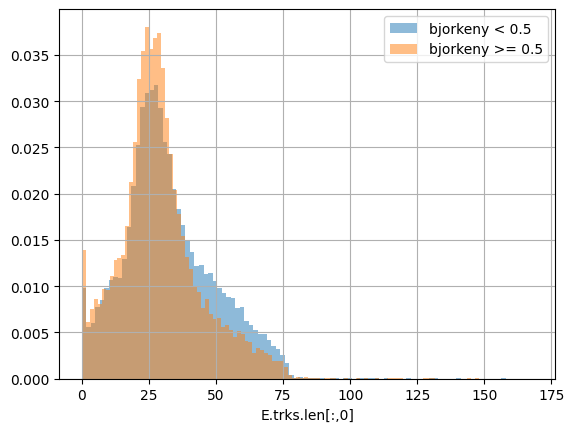

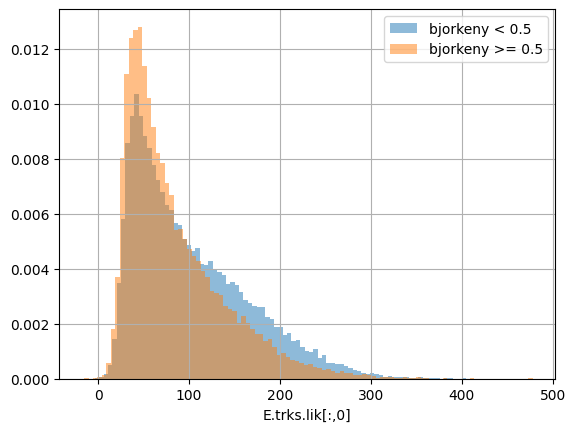

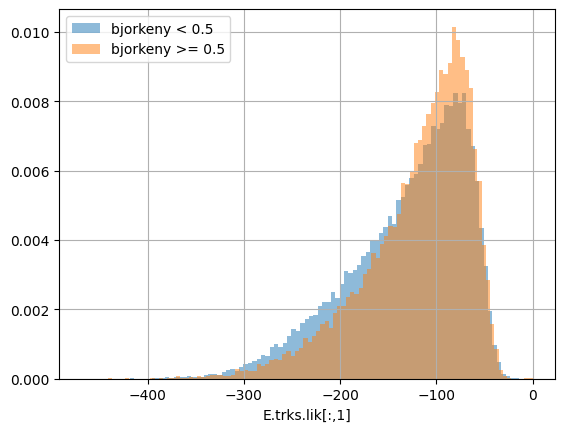

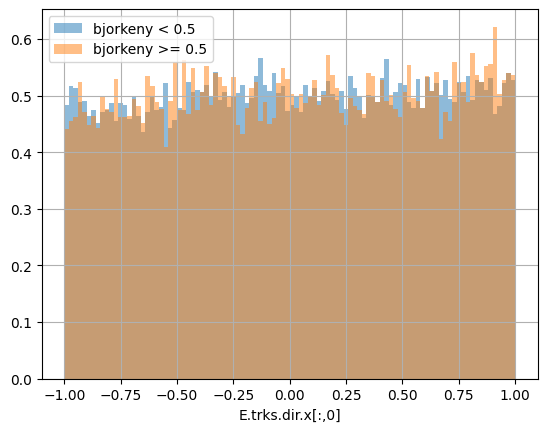

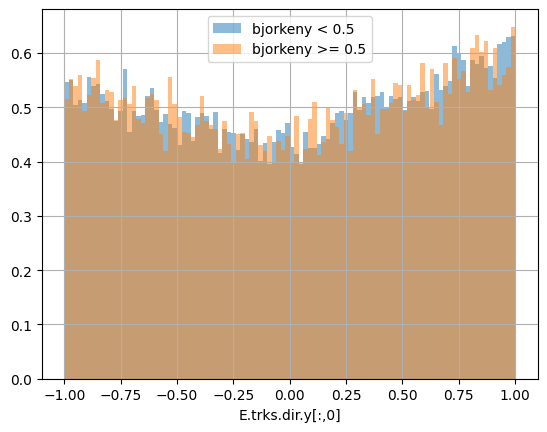

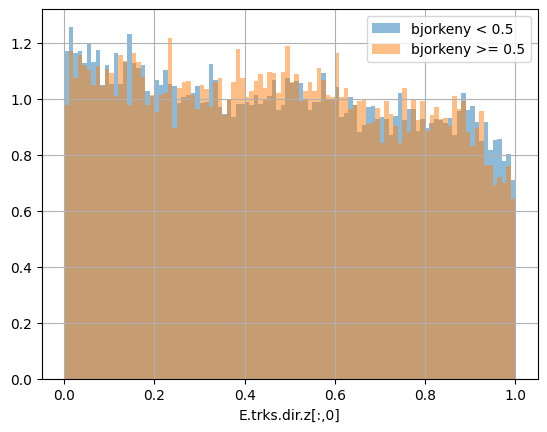

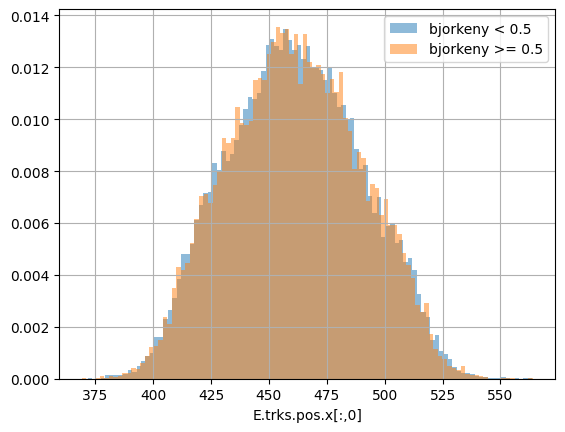

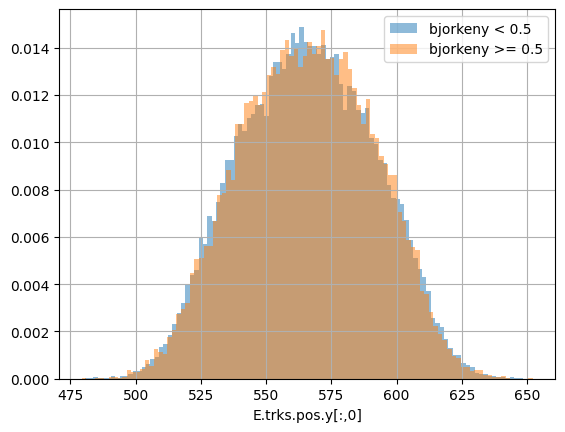

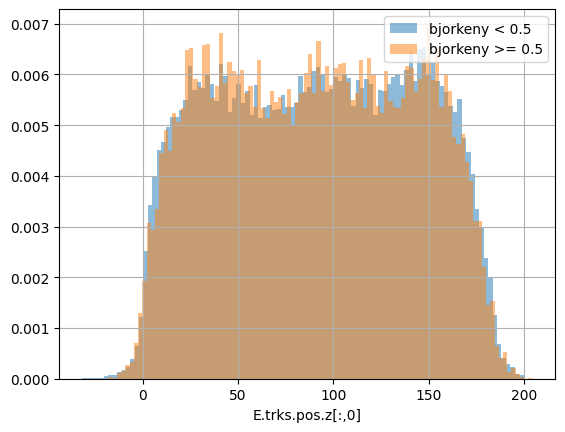

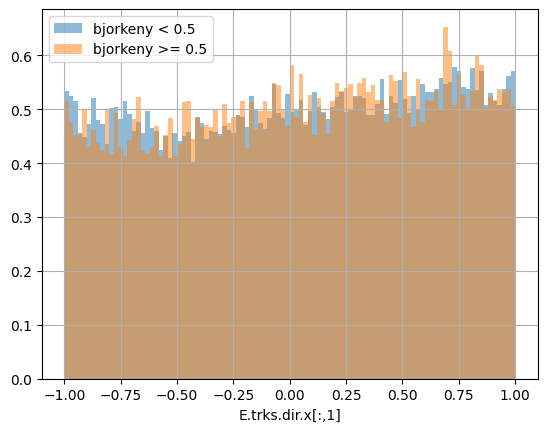

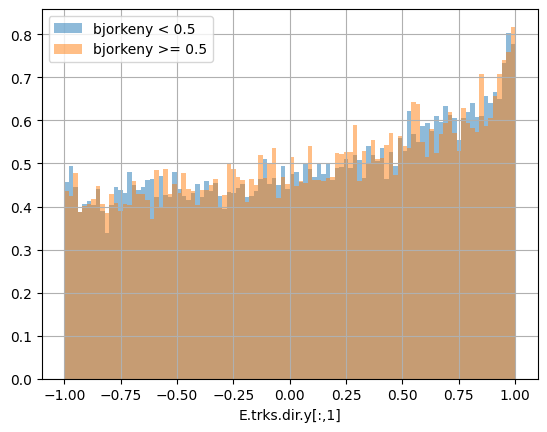

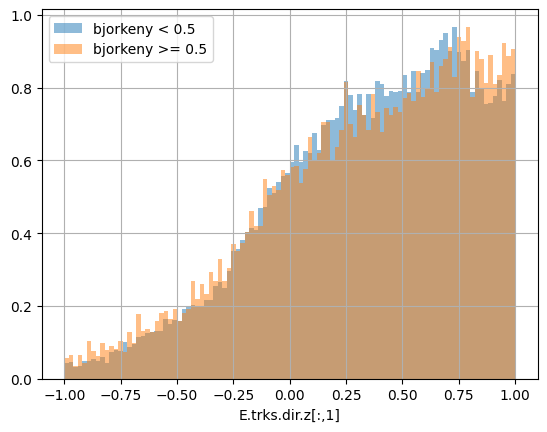

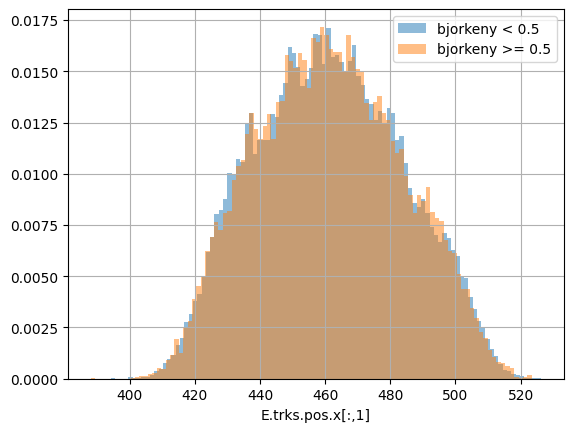

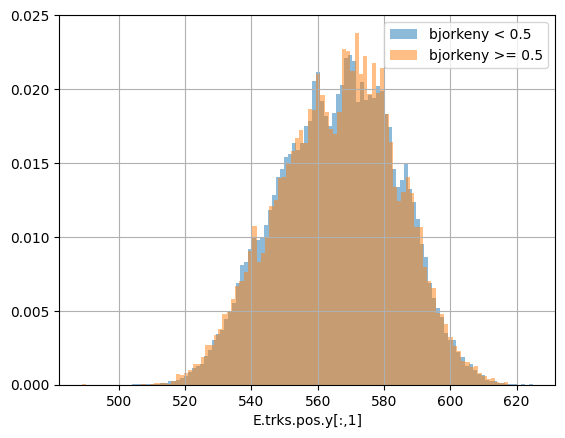

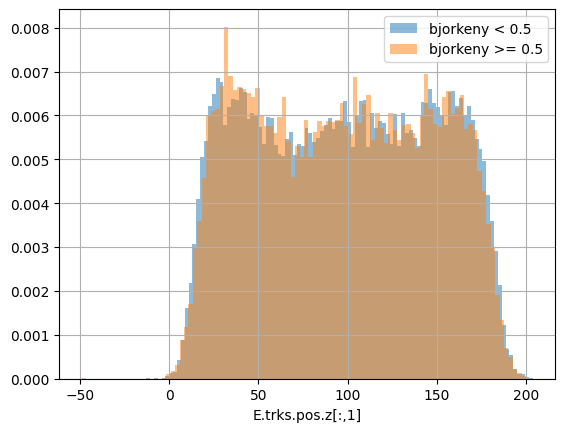

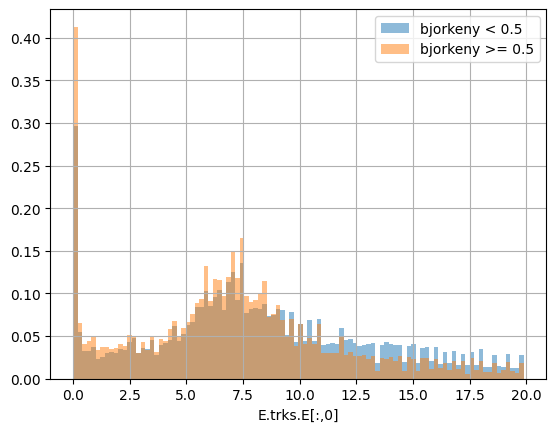

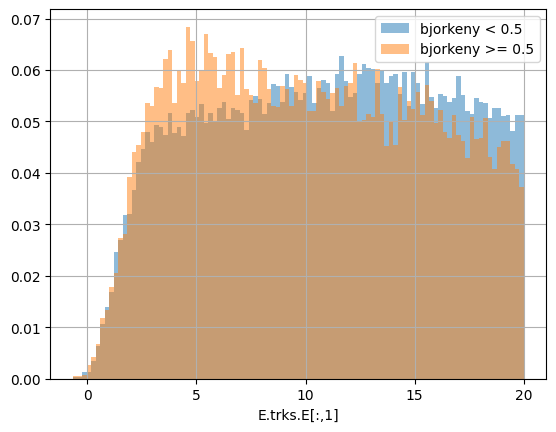

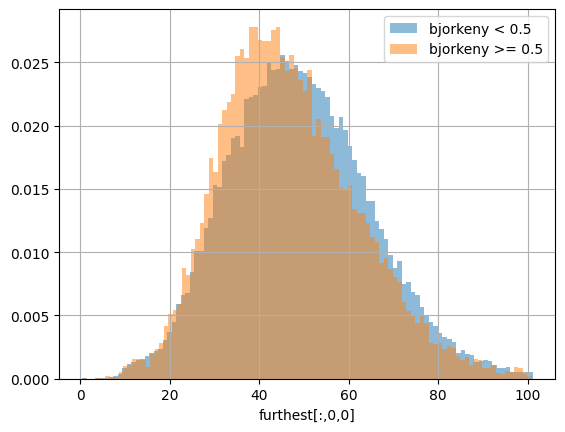

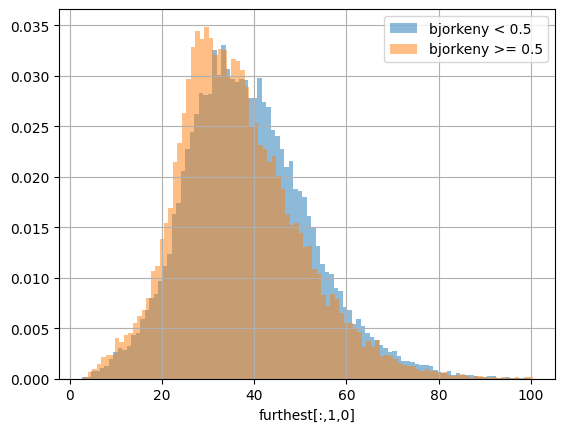

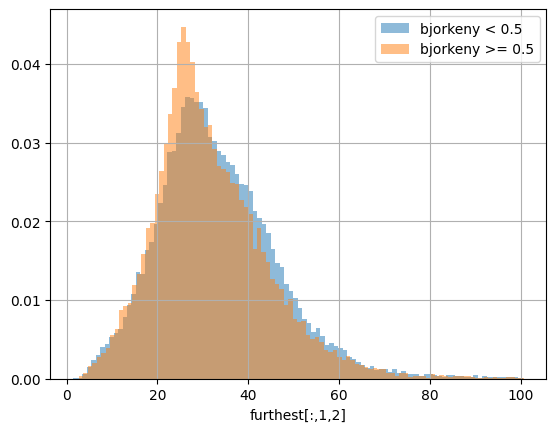

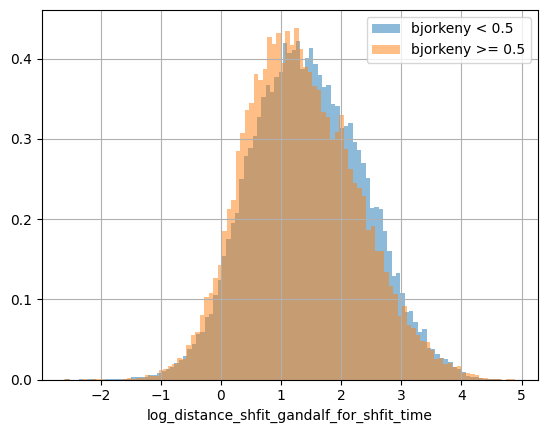

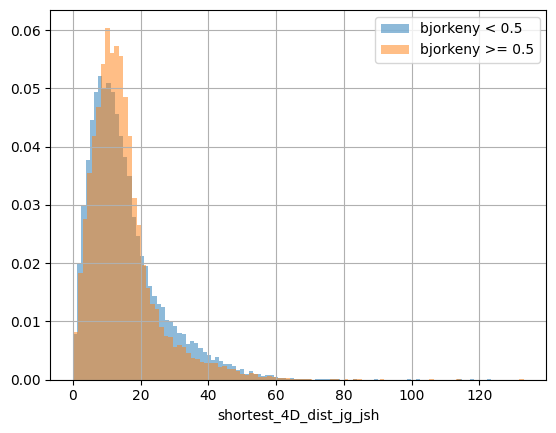

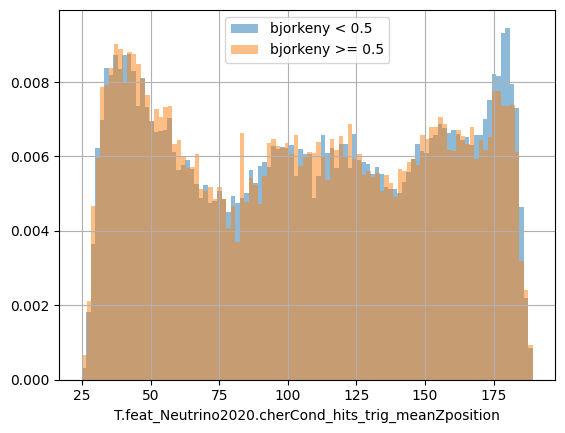

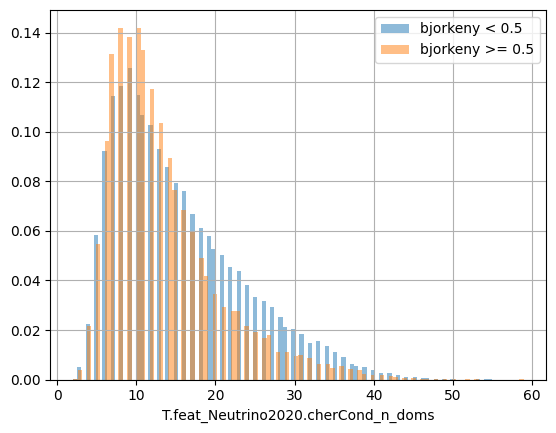

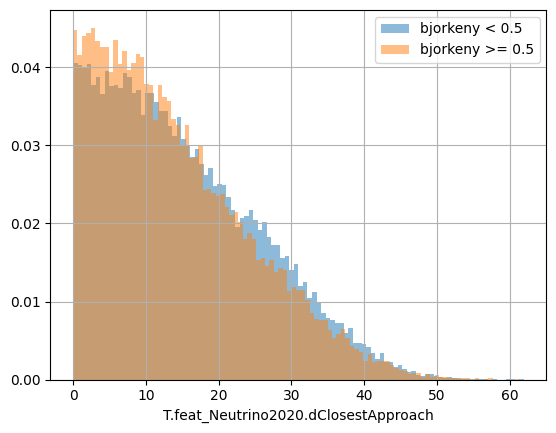

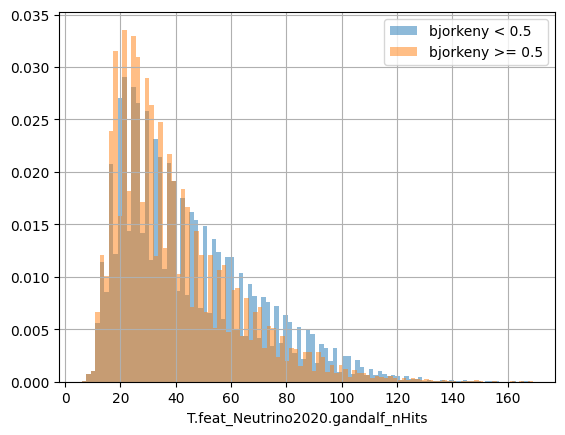

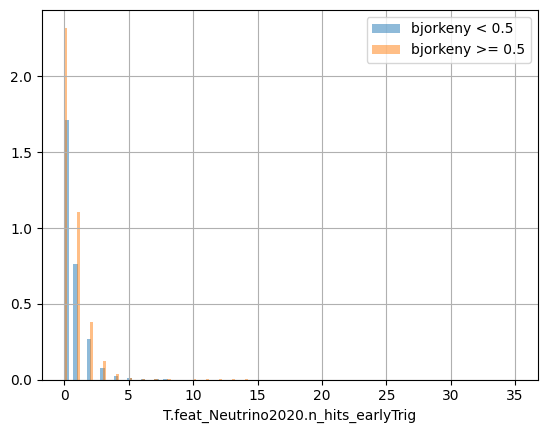

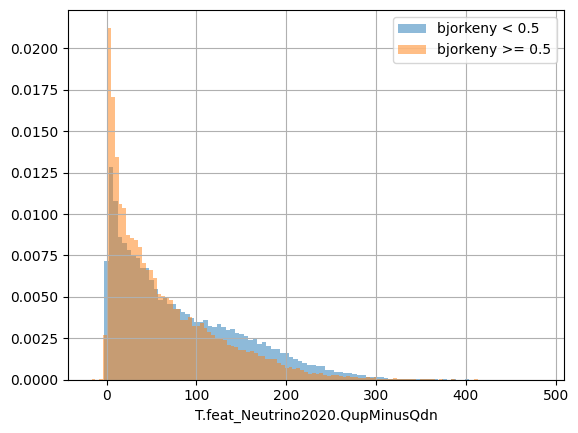

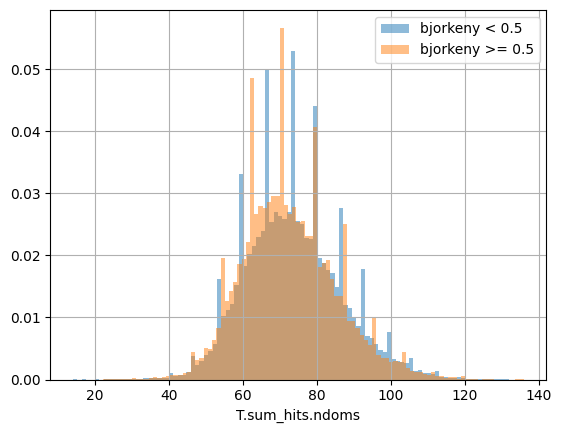

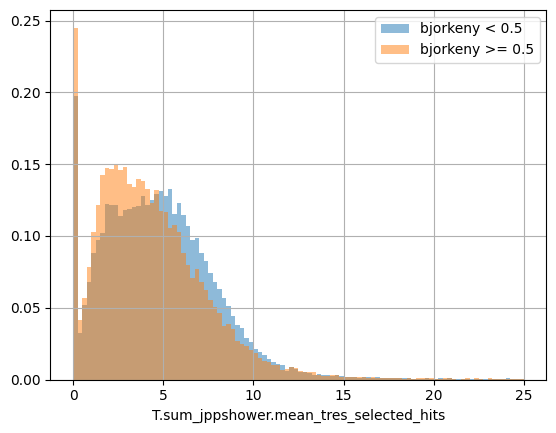

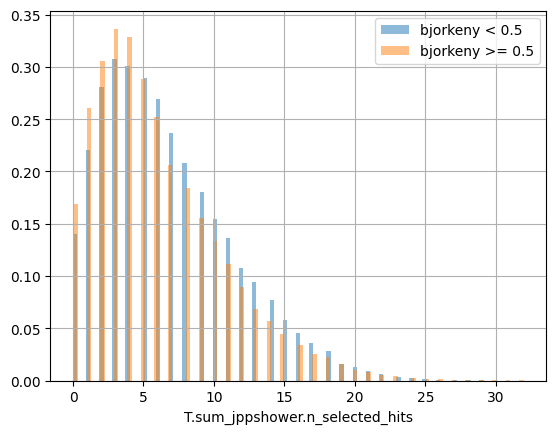

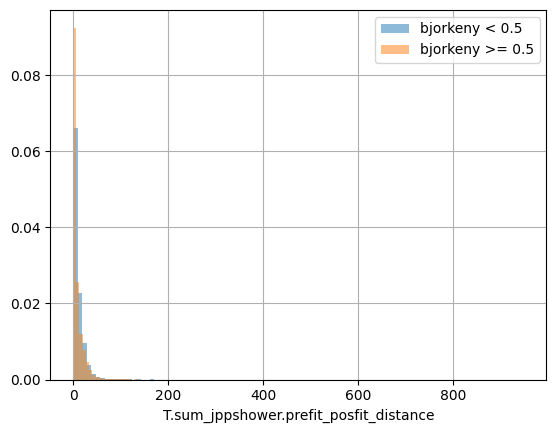

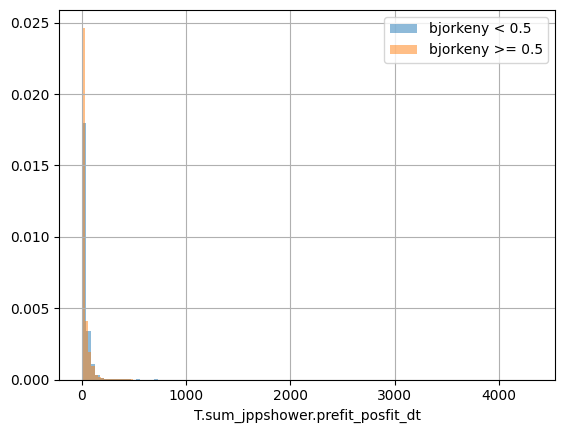

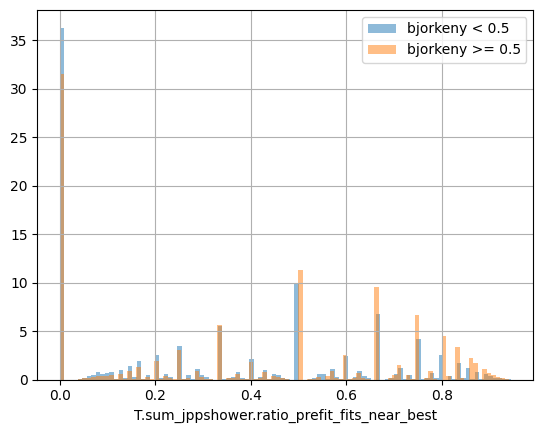

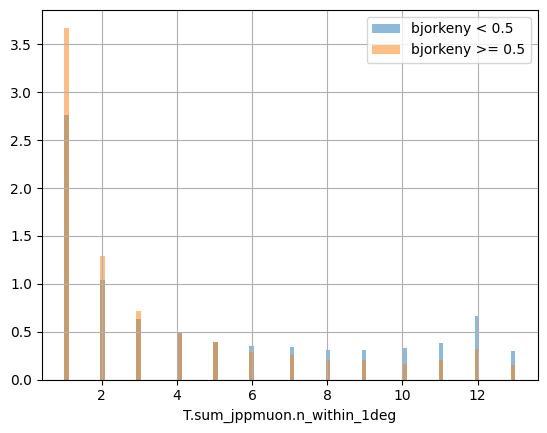

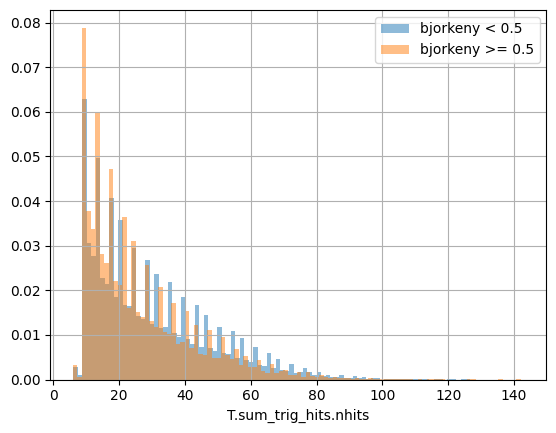

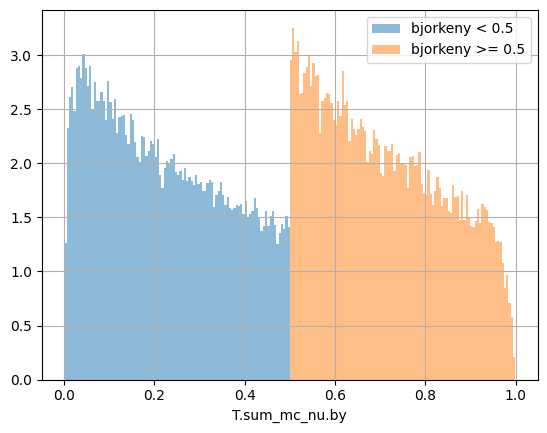

In [44]:
for column in df.columns:
    hist = df[(df["T.sum_mc_nu.by"]<0.5)][column].hist(bins =100, alpha = 0.5, label = "bjorkeny < 0.5", density = True)
    hist = df[(df["T.sum_mc_nu.by"]>=0.5)][column].hist(bins =100, density = True, alpha = 0.5, label = "bjorkeny >= 0.5")
    plt.xlabel(column)
    plt.legend()
    plt.show()    
    # just CC nu mu diff, we know those are tracks
    # print(column)
    # print("n nans ", df[column].isna().sum())
    # hist = df[(abs(df['pdgid'])==14)&(df['is_cc']==1)][column].hist(bins =100, alpha = 0.5, label = "nu_mu CC", density = True)
    # hist = df[(abs(df['pdgid'])!=14)|(df['is_cc']==0)][column].hist(bins =100, density = True, alpha = 0.5, label = "other")
    # plt.xlabel(column)
    # plt.legend()
    # plt.show()

## POST SELECTING DATA/REMOVING OUTLIERS
there are clear variables where the hists seem to indicate there are outliers. Aim to analyse/remove those.

## check certain values

In [12]:
threshold_top_50_2 = df['E.trks.lik[:,1]'].quantile(0.25)
print(threshold_top_50_2)

print(np.unique(df['closest[:,0,0]']))
print(np.unique(df['closest[:,1,2]']))
# print(np.unique(df["E.trks.rec_type[:,1]"]))
print(np.unique(df["E.trks.fitinf[:,0,0]"]))
print(np.max(df["E.trks.fitinf[:,0,0]"]))
# print(np.unique(df["E.trks.fitinf[:,1,0]"]))
print(np.unique(df["E.trks.fitinf[:,0,1]"]))

print(np.max(df["E.trks.fitinf[:,0,1]"]))
# print(np.unique(df["E.trks.fitinf[:,1,1]"]))
print(np.unique(df["T.sum_jppshower.prefit_posfit_dt"]))
print(np.unique(df["T.sum_jppshower.prefit_posfit_distance"]))



-246.15630024267676
[1.93440384e-02 2.13297761e-02 3.39170750e-02 ... 1.01559409e+02
 1.01855447e+02 1.00000000e+20]
[1.55024668e-01 1.66079023e-01 3.48997488e-01 ... 1.01371237e+02
 1.01676961e+02 1.00000000e+20]
[0.00000000e+00 3.80101044e-04 3.81785479e-04 ... 1.17088573e+01
 9.24604316e+01 1.12995344e+02]
112.9953437463257
[0.00000000e+00 2.67189388e-04 2.69675345e-04 ... 3.88355801e+00
 2.84132351e+01 4.32703152e+01]
43.27031517838492
[0.00000000e+00 3.72529030e-09 4.17232513e-06 ... 4.07390320e+04
 5.17748695e+04 1.40907583e+06]
[0.00000000e+00 1.39585320e-11 2.16023128e-11 ... 8.85620684e+03
 4.39976247e+04 6.52504209e+06]


0.015295170733990126


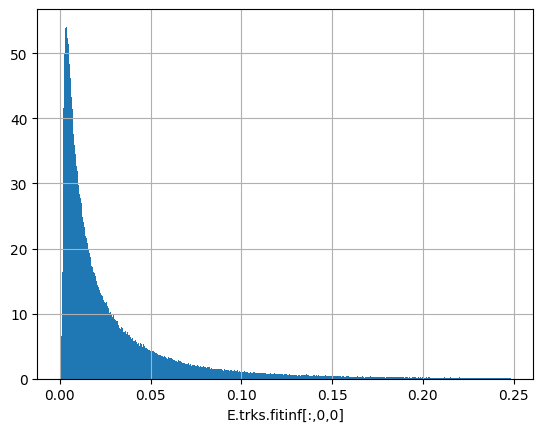

0.010105094072283013


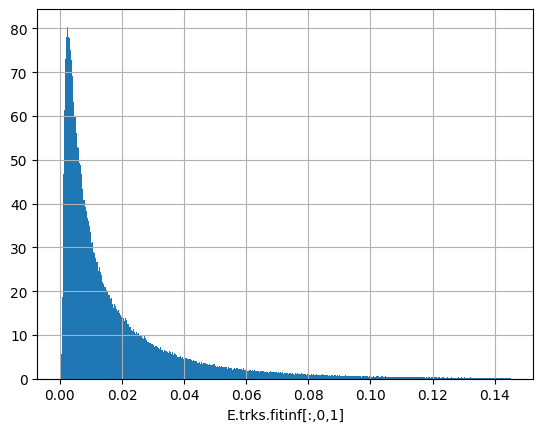

2.0826163217425346


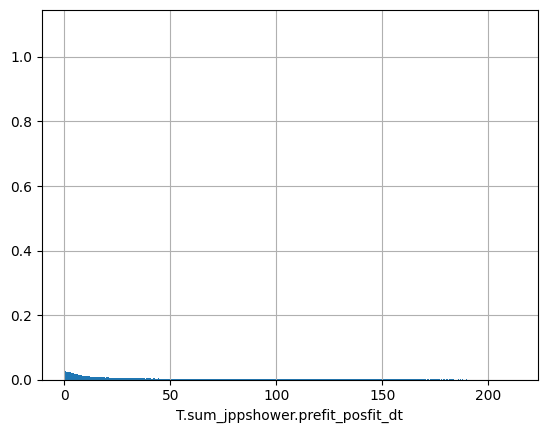

1.053982803540753


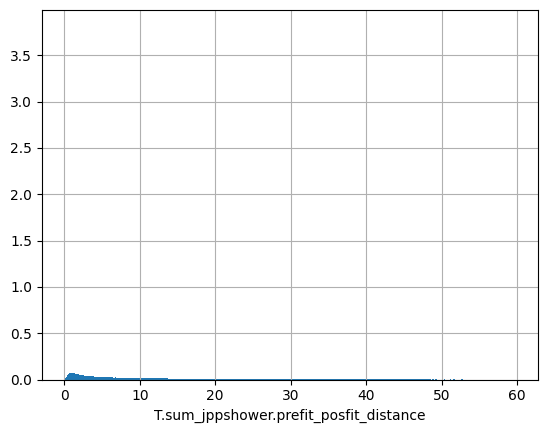

In [27]:
columns = ["E.trks.fitinf[:,0,0]", "E.trks.fitinf[:,0,1]", "T.sum_jppshower.prefit_posfit_dt", "T.sum_jppshower.prefit_posfit_distance"]

for column in columns:
    print(df[column].median())
    hist = df[column].hist(bins = 500, density = True, range = (min(df[column]), df[column].quantile(0.99)))
    plt.xlabel(column)
    plt.show()




## select data

In [3]:
# df = df.drop(columns = ["exposure", "weight", "weight_rate", "E.run_id", "pdgid", "is_cc", "energy"])
# df = df.drop(columns = [column for column in df.columns if len(df[column].unique()) == 1])



# threshold_top_50_1 = df['E.trks.lik[:,0]'].quantile(0.75)
# threshold_top_50_2 = df['E.trks.lik[:,1]'].quantile(0.25)

# print(threshold_top_50_1, threshold_top_50_2)

# df = df[np.invert((df['E.trks.dir.x[:,1]']==0)&(df['E.trks.dir.y[:,1]']==0)&(df['E.trks.dir.z[:,1]']==0))]
# df = df[(df['E.trks.lik[:,0]']>threshold_top_50_1)] #| (df['E.trks.lik[:,1]']<threshold_top_50_2)]


# df = df[(df["E.trks.lik[:,0]"]>np.quantile(df["E.trks.lik[:,0]"], 0.8))   | (df["E.trks.lik[:,1]"] < np.quantile(df["E.trks.lik[:,1]"], 0.2))]
# df = df[(df["E.trks.fitinf[:,0,0]"]<np.quantile(df["E.trks.fitinf[:,0,0]"], 0.95)) & (df["E.trks.fitinf[:,0,1]"]<np.quantile(df["E.trks.fitinf[:,0,1]"], 0.95)) & (df["T.sum_jppshower.prefit_posfit_dt"]<np.quantile(df["T.sum_jppshower.prefit_posfit_dt"], 0.95)) & (df["T.sum_jppshower.prefit_posfit_distance"]<np.quantile(df["T.sum_jppshower.prefit_posfit_distance"], 0.95))]
# df = df[np.invert((df['closest[:,0,0]']==1e20) | (df['closest[:,1,0]']==1e20) | (df['closest[:,1,2]']==1e20) | (df['closest[:,0,1]']==1e20)  )] 

current_counts = df["pdgid"].value_counts()
# print(current_counts/original_counts)

# df = df[df["T.sum_mc_nu.by"]>0.5]

df = df.drop(columns = ["exposure", "weight", "weight_rate", "E.run_id", "pdgid", "is_cc", "energy"])
df = df.drop(columns = [column for column in df.columns if len(df[column].unique()) ==1])
print(df.info())



<class 'pandas.core.frame.DataFrame'>
Index: 137253 entries, 1100 to 235589
Data columns (total 54 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   angle_shfit_gandalf                                   137253 non-null  float64
 1   closest[:,0,0]                                        137253 non-null  float64
 2   closest[:,0,1]                                        137253 non-null  float64
 3   closest[:,1,0]                                        137253 non-null  float64
 4   closest[:,1,2]                                        137253 non-null  float64
 5   crkv_nhits100[:,0,0]                                  137253 non-null  int32  
 6   crkv_nhits100[:,0,2]                                  137253 non-null  int32  
 7   crkv_nhits100[:,1,2]                                  137253 non-null  int32  
 8   crkv_nhits50[:,0,0]                           

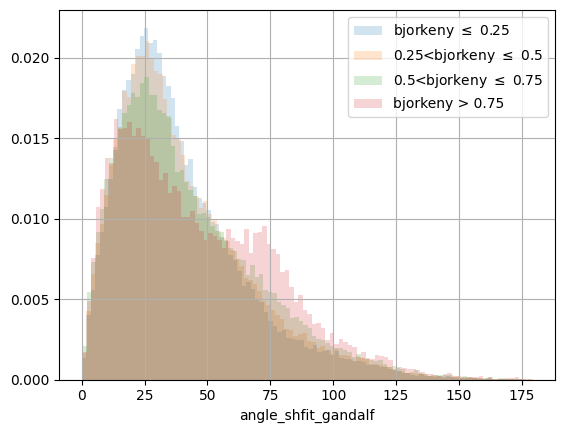

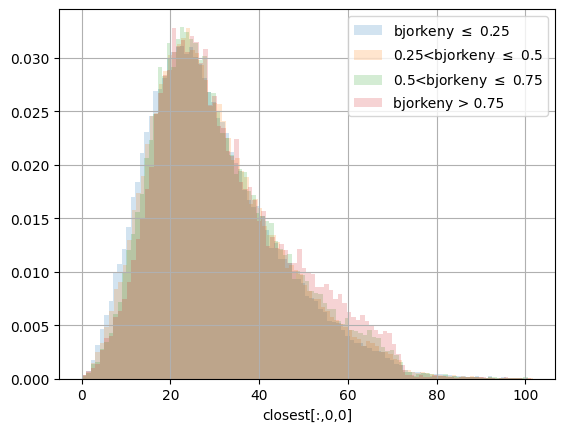

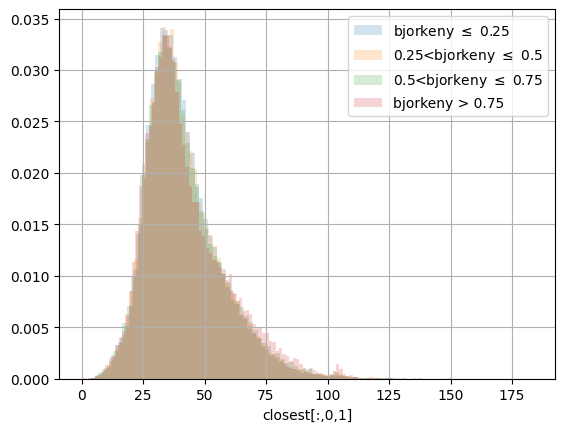

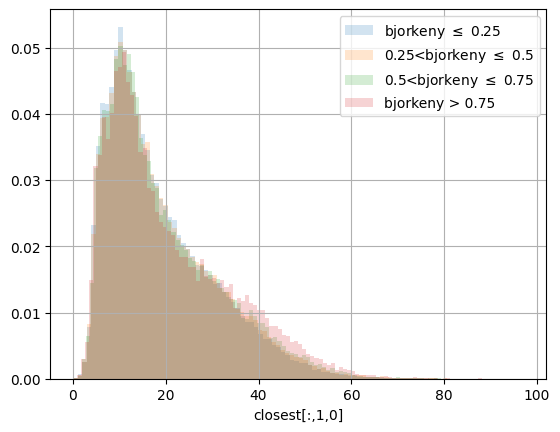

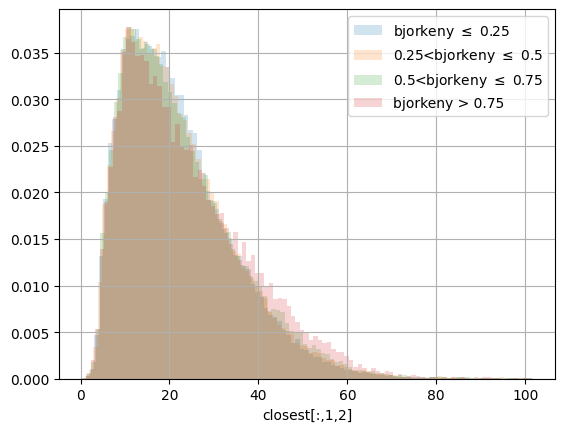

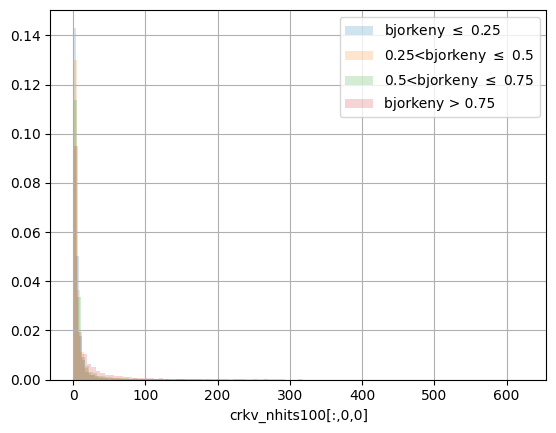

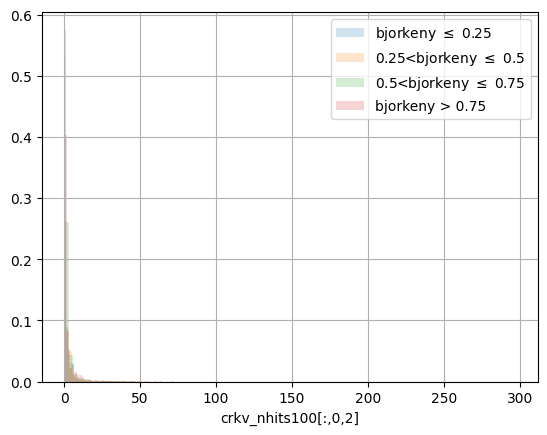

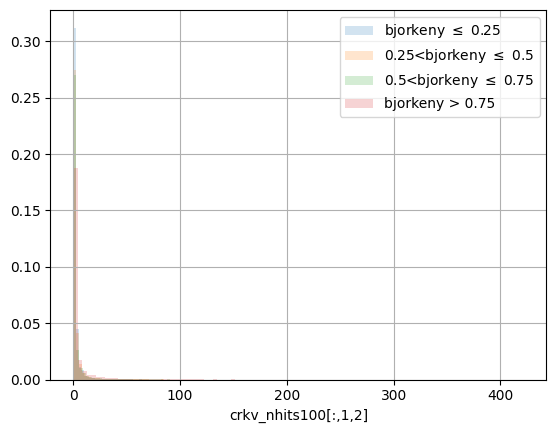

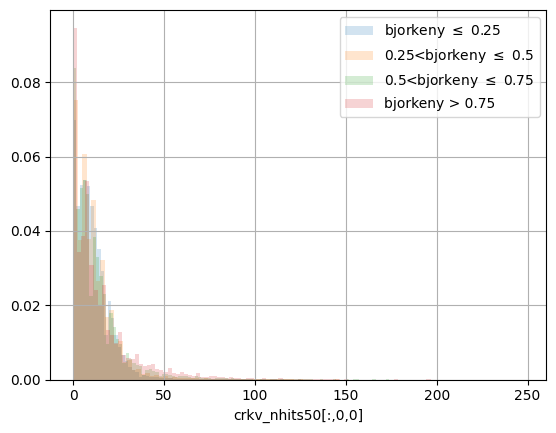

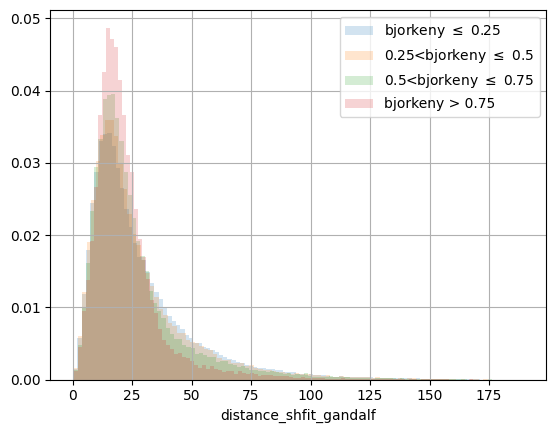

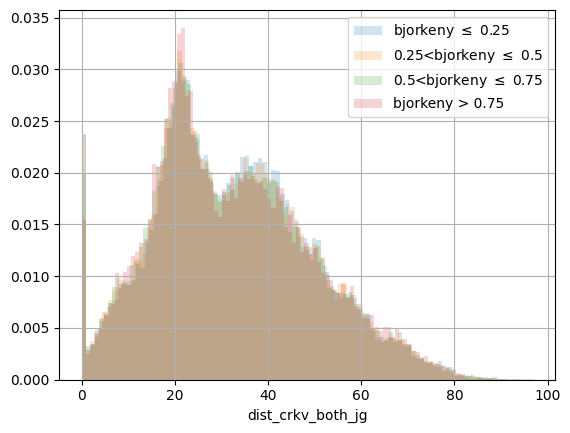

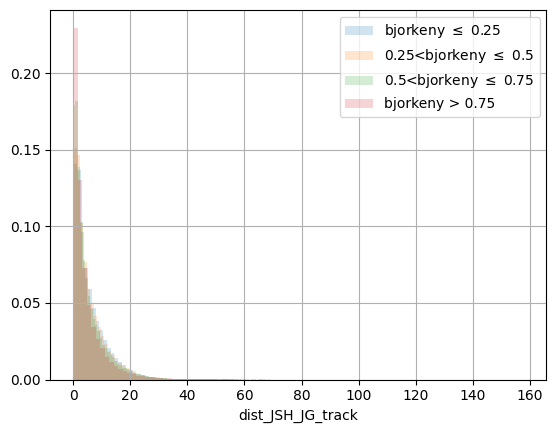

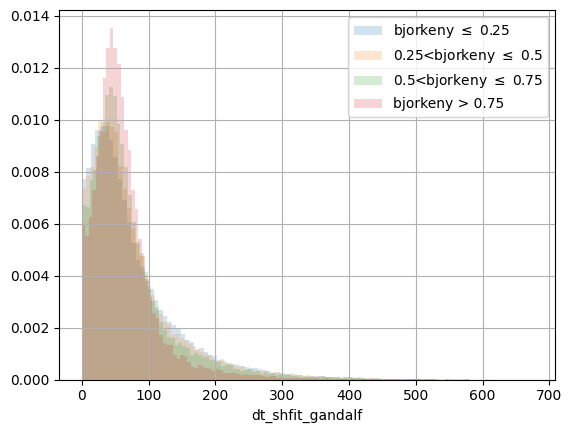

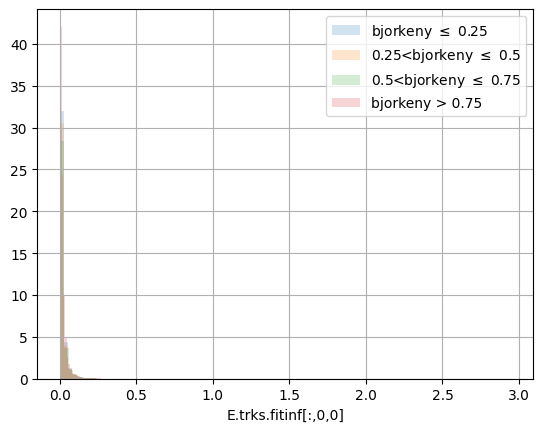

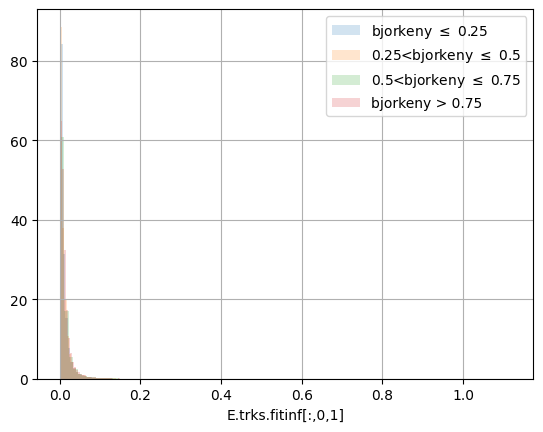

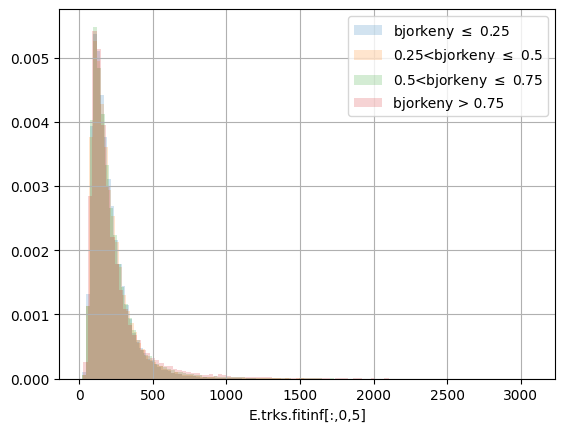

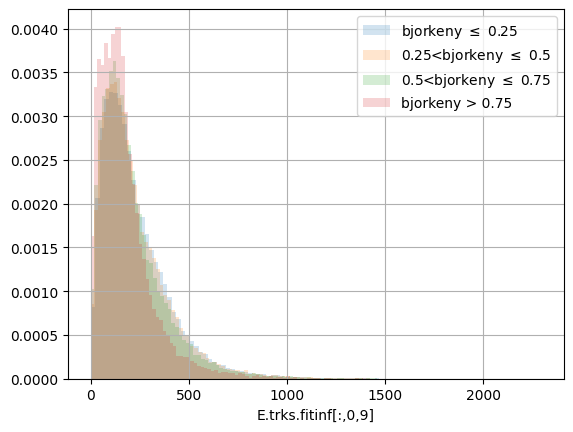

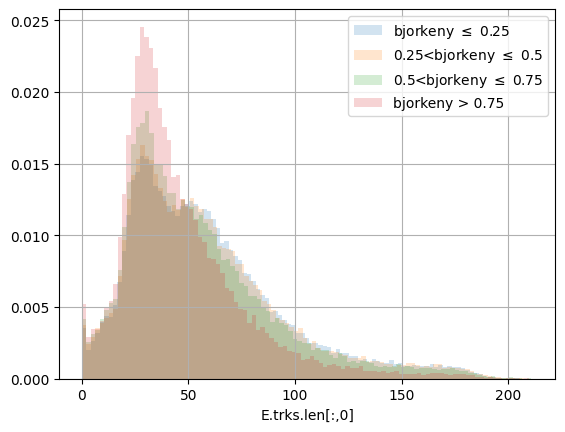

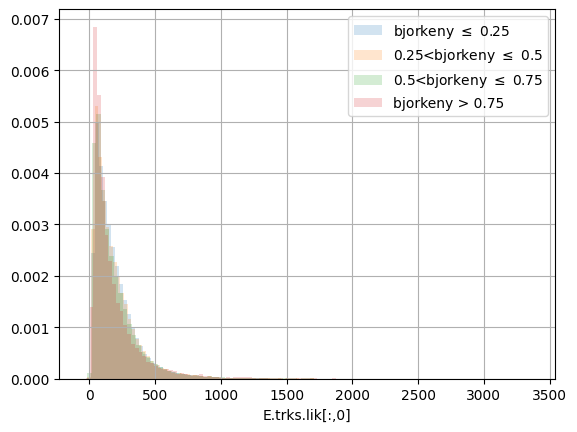

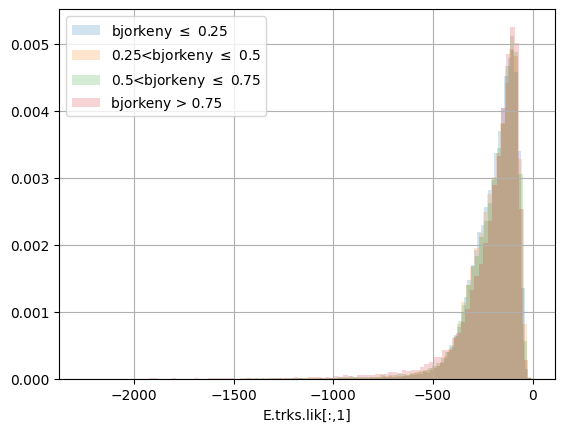

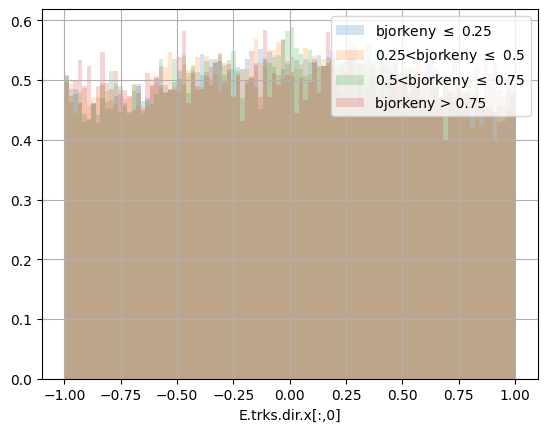

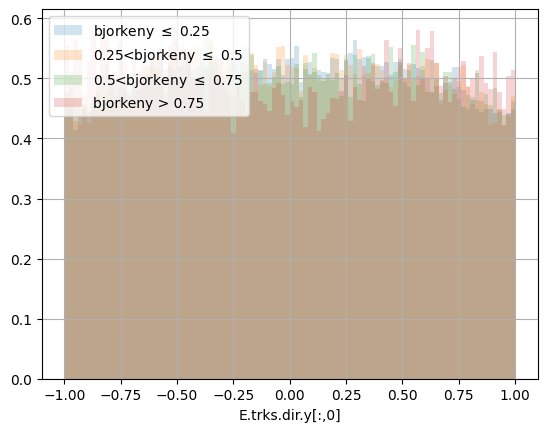

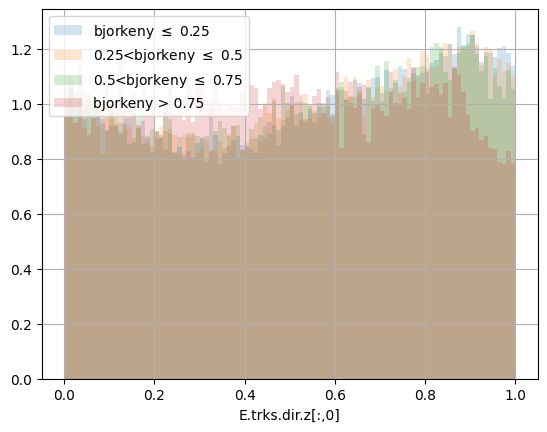

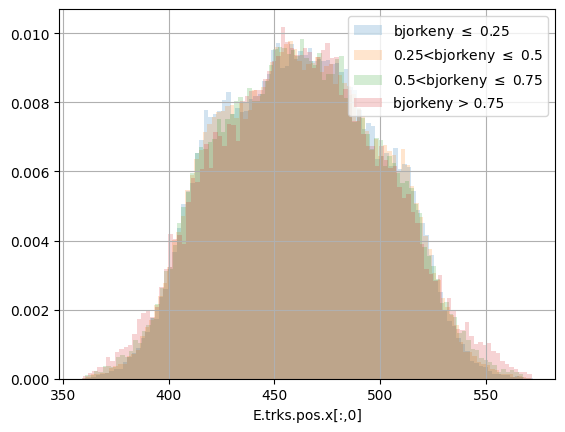

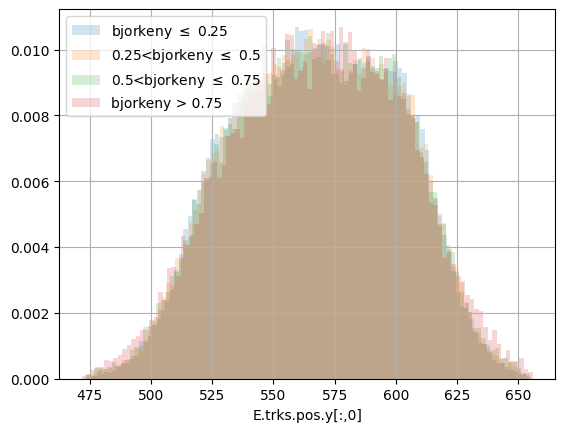

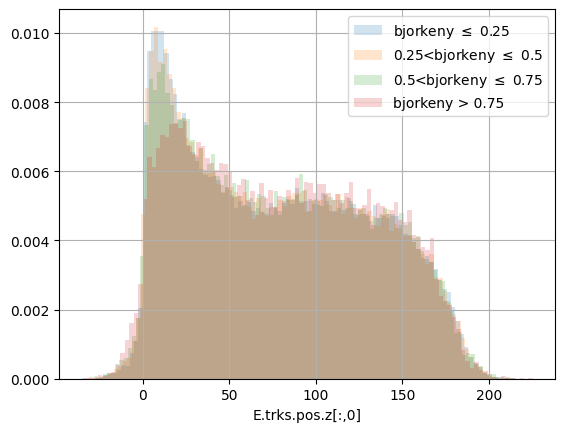

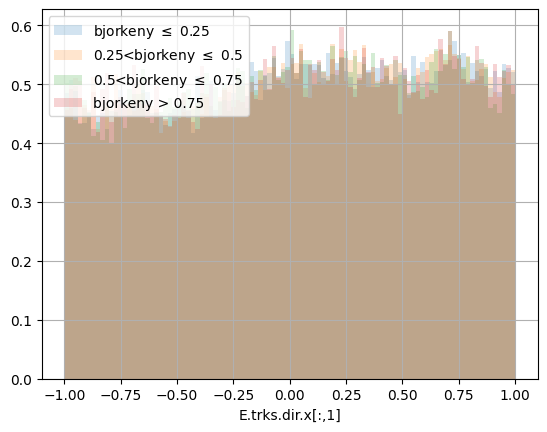

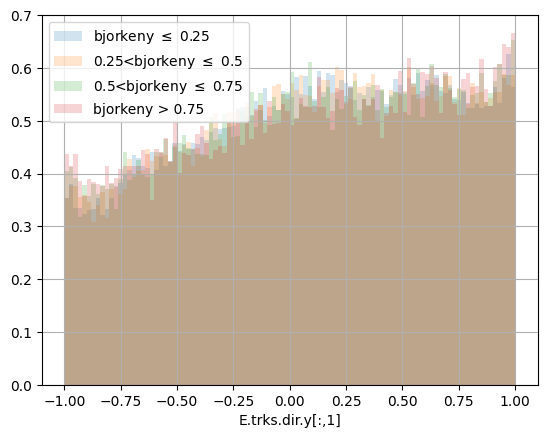

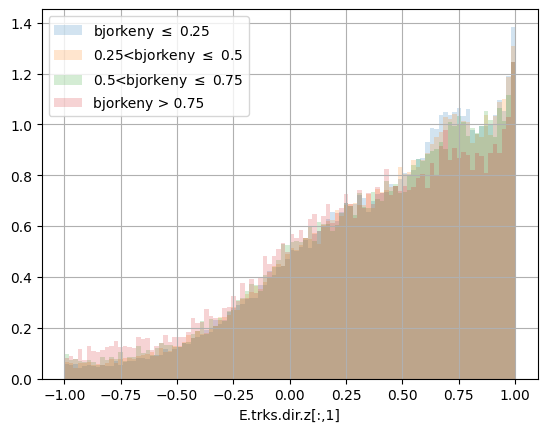

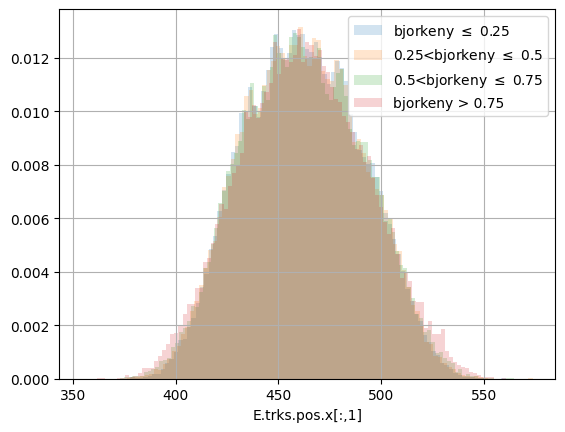

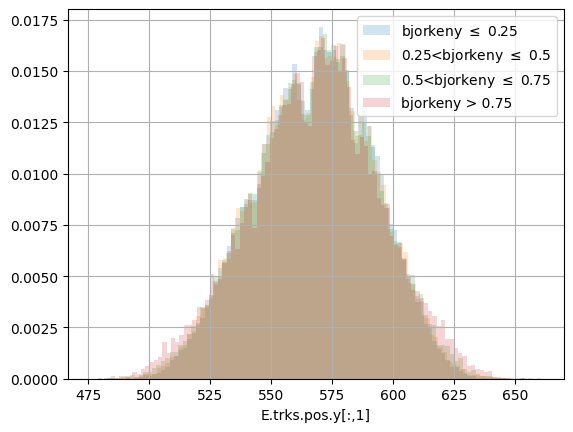

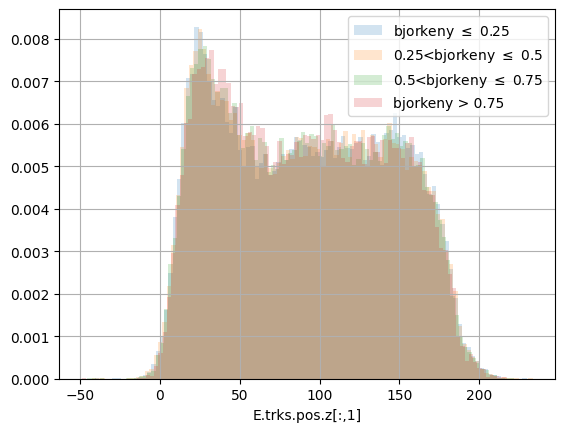

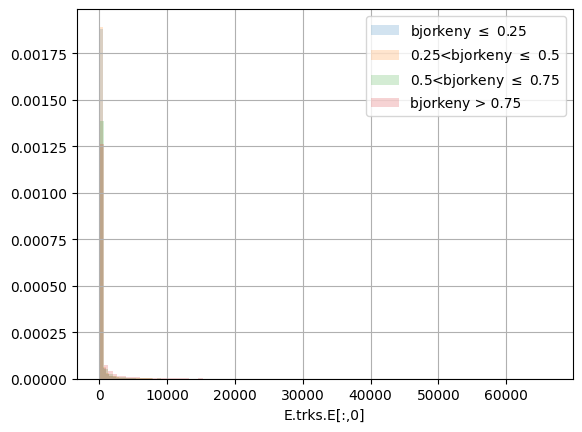

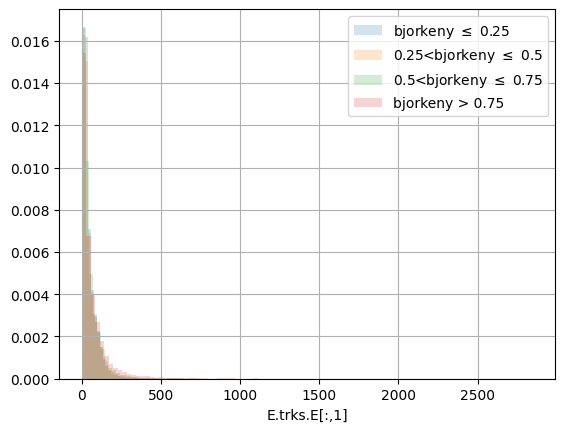

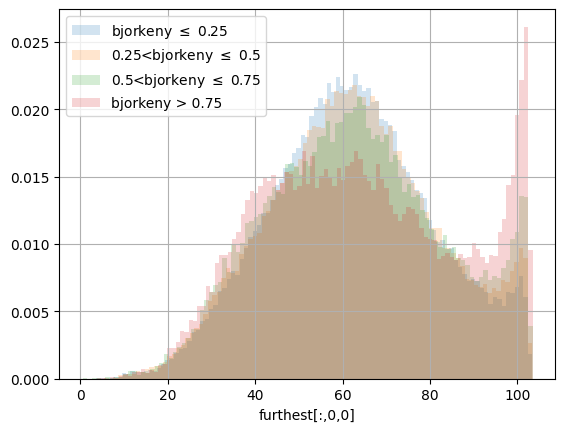

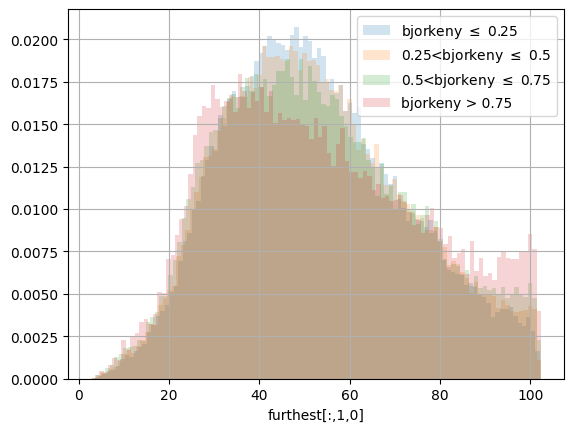

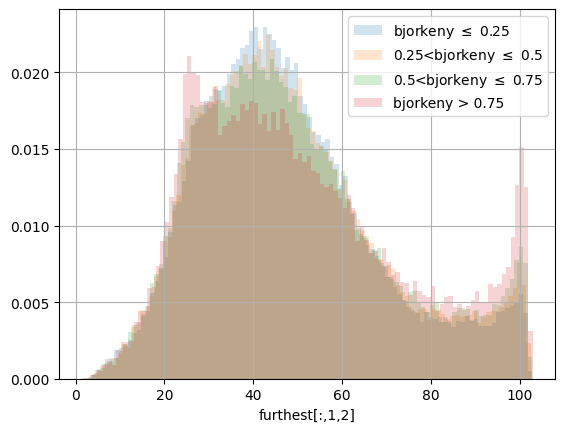

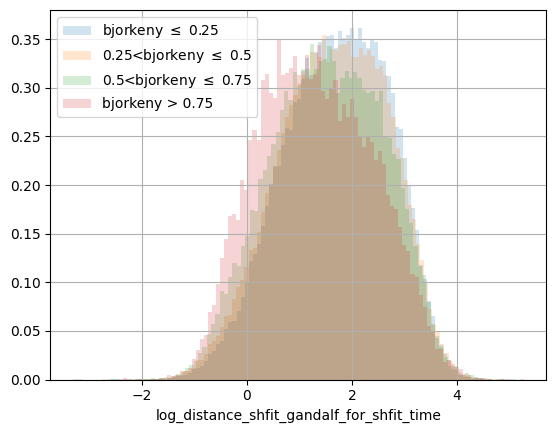

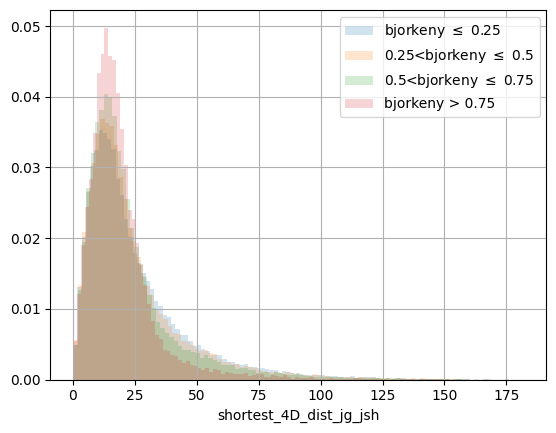

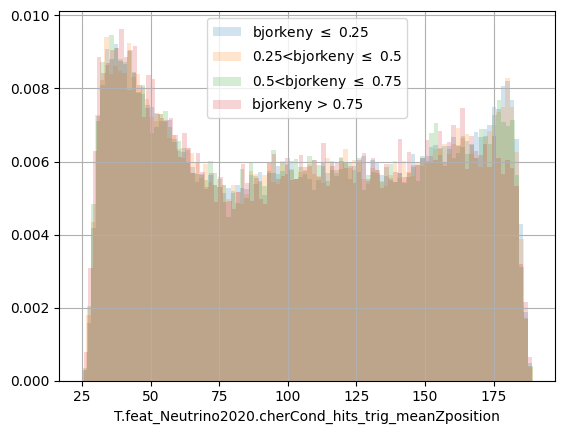

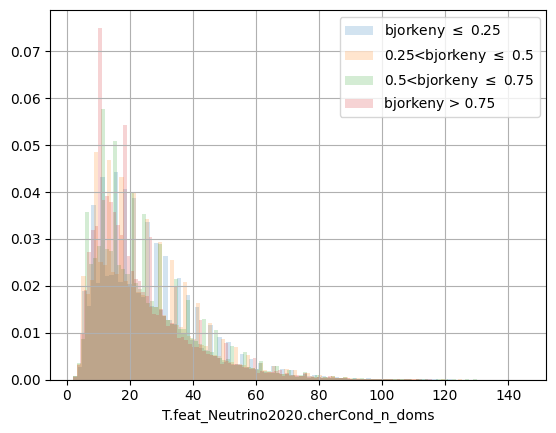

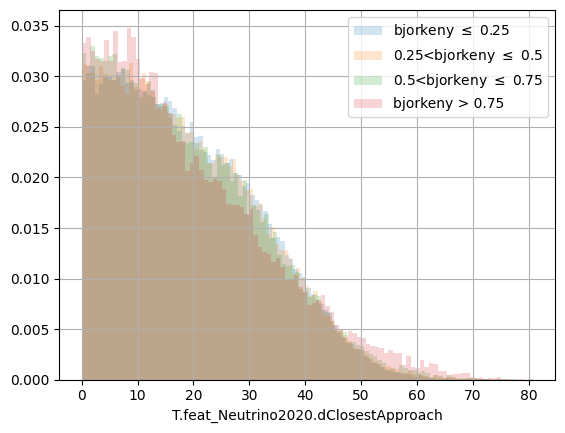

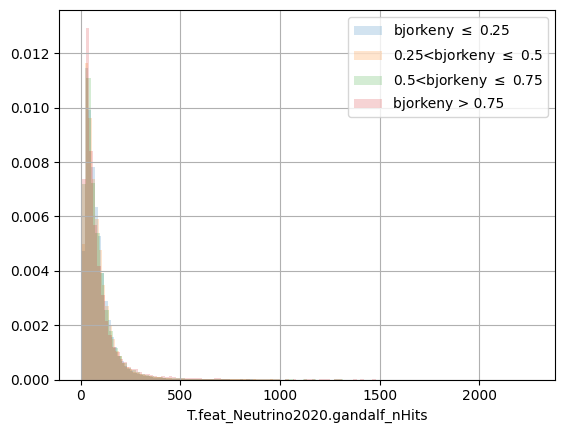

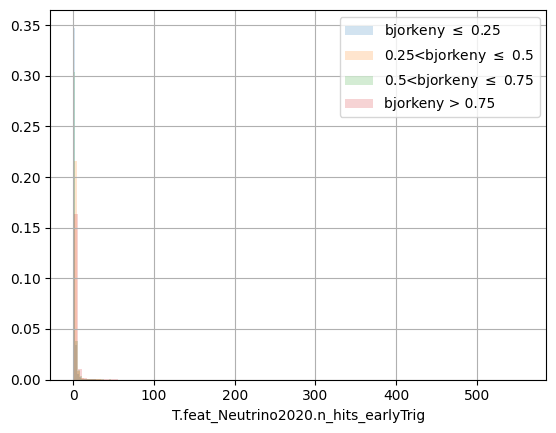

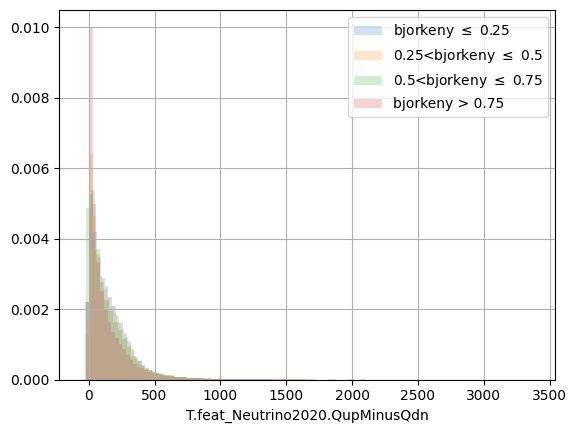

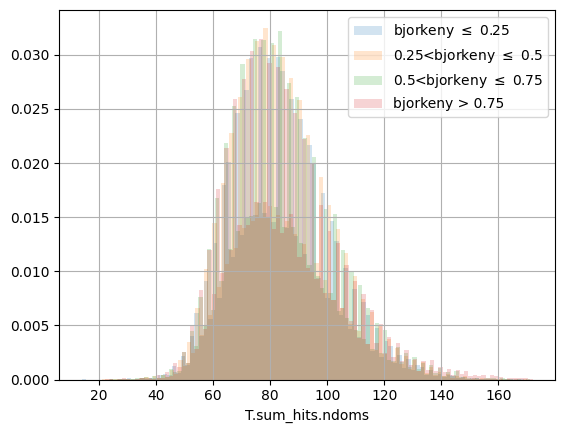

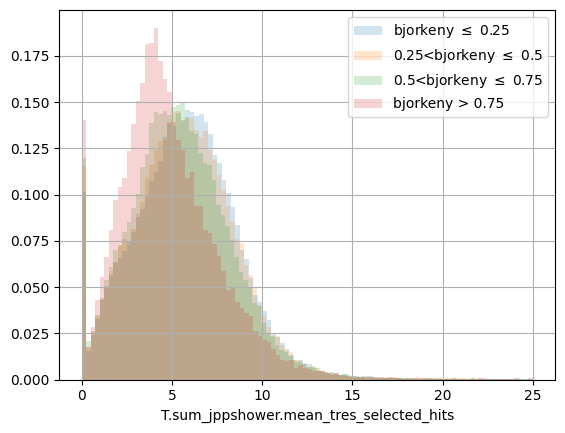

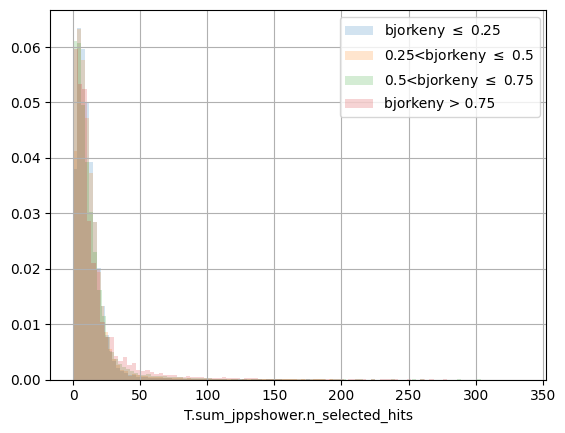

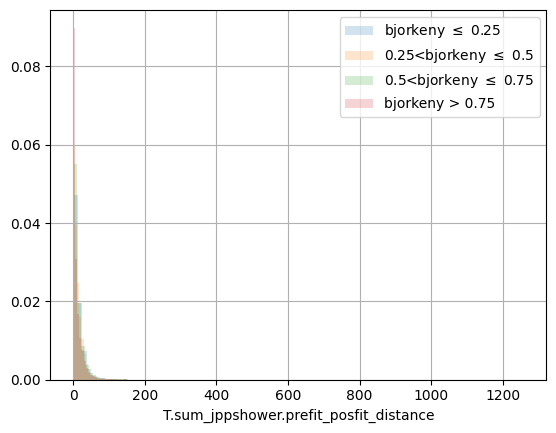

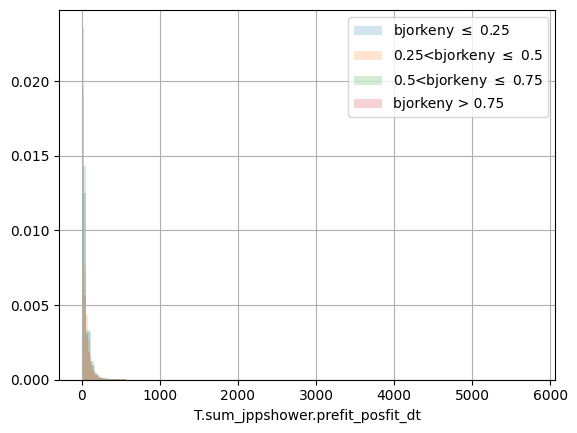

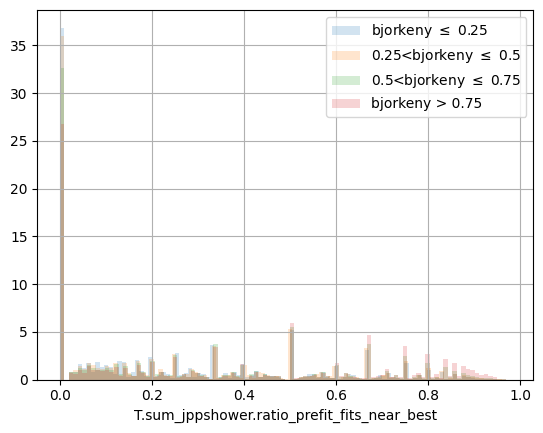

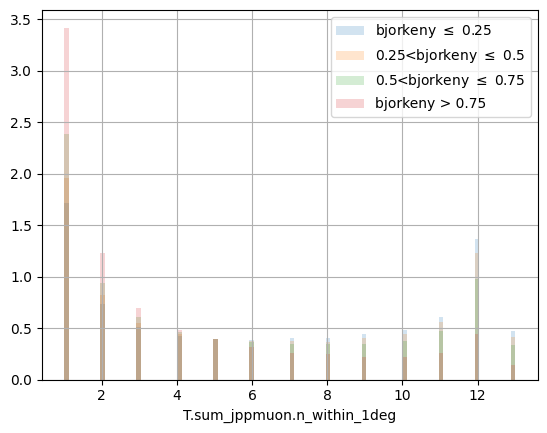

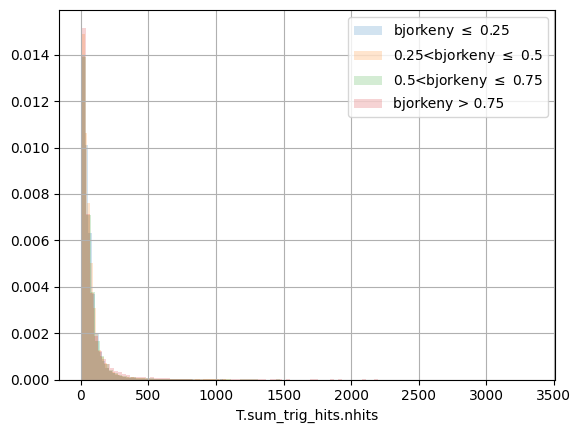

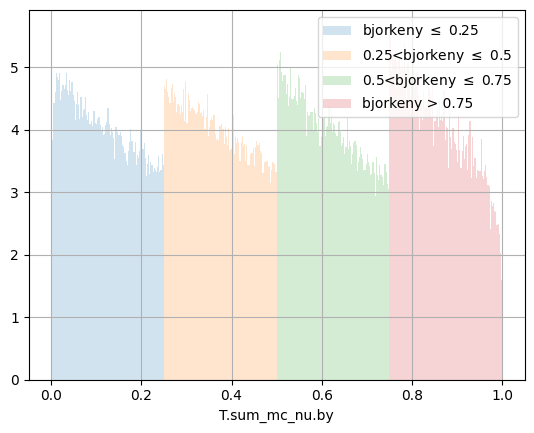

In [216]:
alpha = 0.2
for column in df.columns:
    hist1 = df[df["T.sum_mc_nu.by"]<= 0.25][column].hist(bins = 100, alpha = alpha, label = "bjorkeny $\leq$ 0.25", density = True)
    hist2 = df[(df["T.sum_mc_nu.by"]> 0.25)& (df["T.sum_mc_nu.by"]<= 0.5)][column].hist(bins = 100, alpha = alpha, label = "0.25<bjorkeny $\leq$ 0.5", density = True)
    hist3 = df[(df["T.sum_mc_nu.by"]> 0.5)& (df["T.sum_mc_nu.by"]<= 0.75)][column].hist(bins = 100, alpha = alpha, label = "0.5<bjorkeny $\leq$ 0.75", density = True)
    hist4 = df[(df["T.sum_mc_nu.by"]> 0.75)][column].hist(bins = 100, alpha = alpha, label = "bjorkeny > 0.75", density = True)
    plt.xlabel(column)
    plt.legend()
    plt.show()

## optimize for correlation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


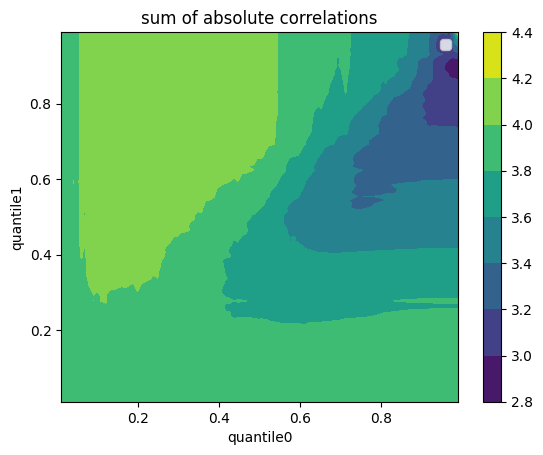

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(100, 100)
(100, 100)


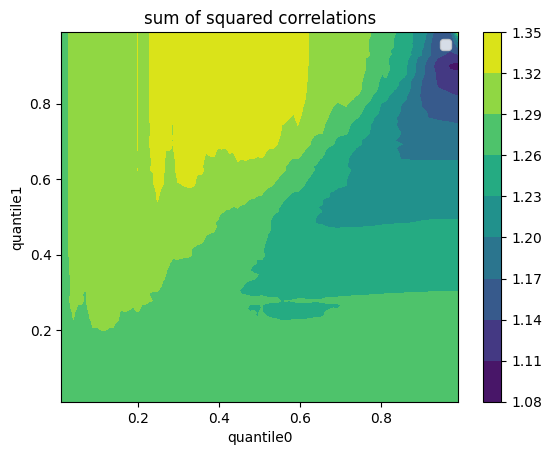

In [32]:
df_test = df
# # df_test = df_test[np.invert((df_test['closest[:,0,0]']==1e20) | (df_test['closest[:,1,0]']==1e20) | (df_test['closest[:,1,2]']==1e20) | (df_test['closest[:,0,1]']==1e20)  )] 
quantiles_0 = np.linspace(0.01, 0.99, 100)
quantiles_1 = np.linspace(0.01, 0.99, 100)
tot_abs_cors = []
tot_sq_cors = []
for quantile_0 in quantiles_0:
        for quantile_1 in quantiles_1:

            df_corr = df_test[(df_test["E.trks.lik[:,0]"]>np.quantile(df_test["E.trks.lik[:,0]"], quantile_0)) | (df_test["E.trks.lik[:,1]"] < np.quantile(df_test["E.trks.lik[:,1]"], 1-quantile_1))]
            corr = df_corr.corr()
            bjorkeny_corr = corr['T.sum_mc_nu.by']
            tot_abs_cors.append(abs(bjorkeny_corr).sum())
            tot_sq_cors.append((bjorkeny_corr**2).sum())


X, Y = np.meshgrid(quantiles_0, quantiles_1)
plt.contourf(X, Y, np.array(tot_abs_cors).reshape(X.shape))
plt.colorbar()
plt.xlabel("quantile0")
plt.ylabel("quantile1")
plt.legend()
plt.title("sum of absolute correlations")
plt.show()


print(X.shape)
print(Y.shape)
plt.contourf(X, Y, np.array(tot_sq_cors).reshape(X.shape))
plt.colorbar()
plt.xlabel("quantile0")
plt.ylabel("quantile1")
plt.legend()
plt.title("sum of squared correlations")
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


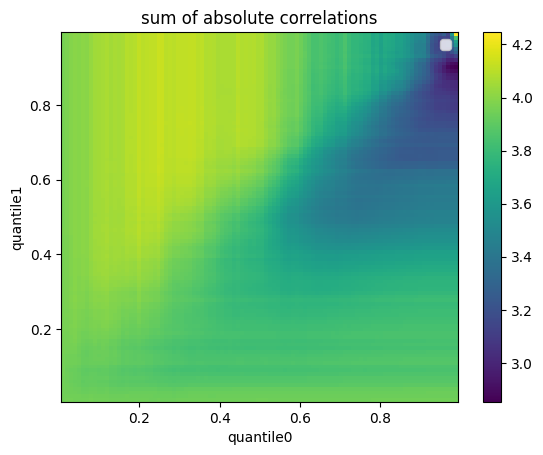

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


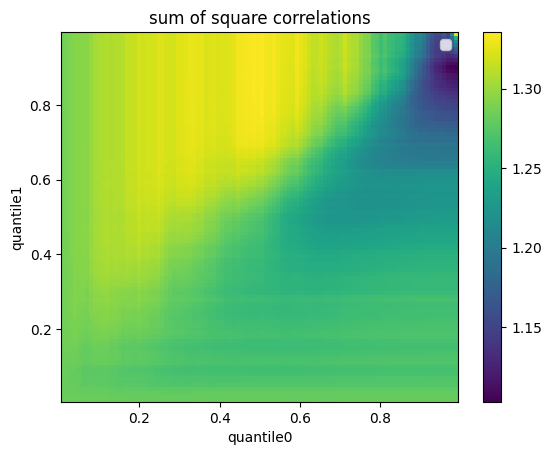

In [34]:
plt.pcolormesh(X, Y, np.array(tot_abs_cors).reshape(X.shape))
plt.colorbar()
plt.xlabel("quantile0")
plt.ylabel("quantile1")
plt.legend()
plt.title("sum of absolute correlations")
plt.show()

plt.pcolormesh(X, Y, np.array(tot_sq_cors).reshape(X.shape))
plt.colorbar()
plt.xlabel("quantile0")
plt.ylabel("quantile1")
plt.legend()
plt.title("sum of square correlations")
plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 60515 entries, 1117 to 235584
Data columns (total 54 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   angle_shfit_gandalf                                   60515 non-null  float64
 1   closest[:,0,0]                                        60515 non-null  float64
 2   closest[:,0,1]                                        60515 non-null  float64
 3   closest[:,1,0]                                        60515 non-null  float64
 4   closest[:,1,2]                                        60515 non-null  float64
 5   crkv_nhits100[:,0,0]                                  60515 non-null  int32  
 6   crkv_nhits100[:,0,2]                                  60515 non-null  int32  
 7   crkv_nhits100[:,1,2]                                  60515 non-null  int32  
 8   crkv_nhits50[:,0,0]                                   605

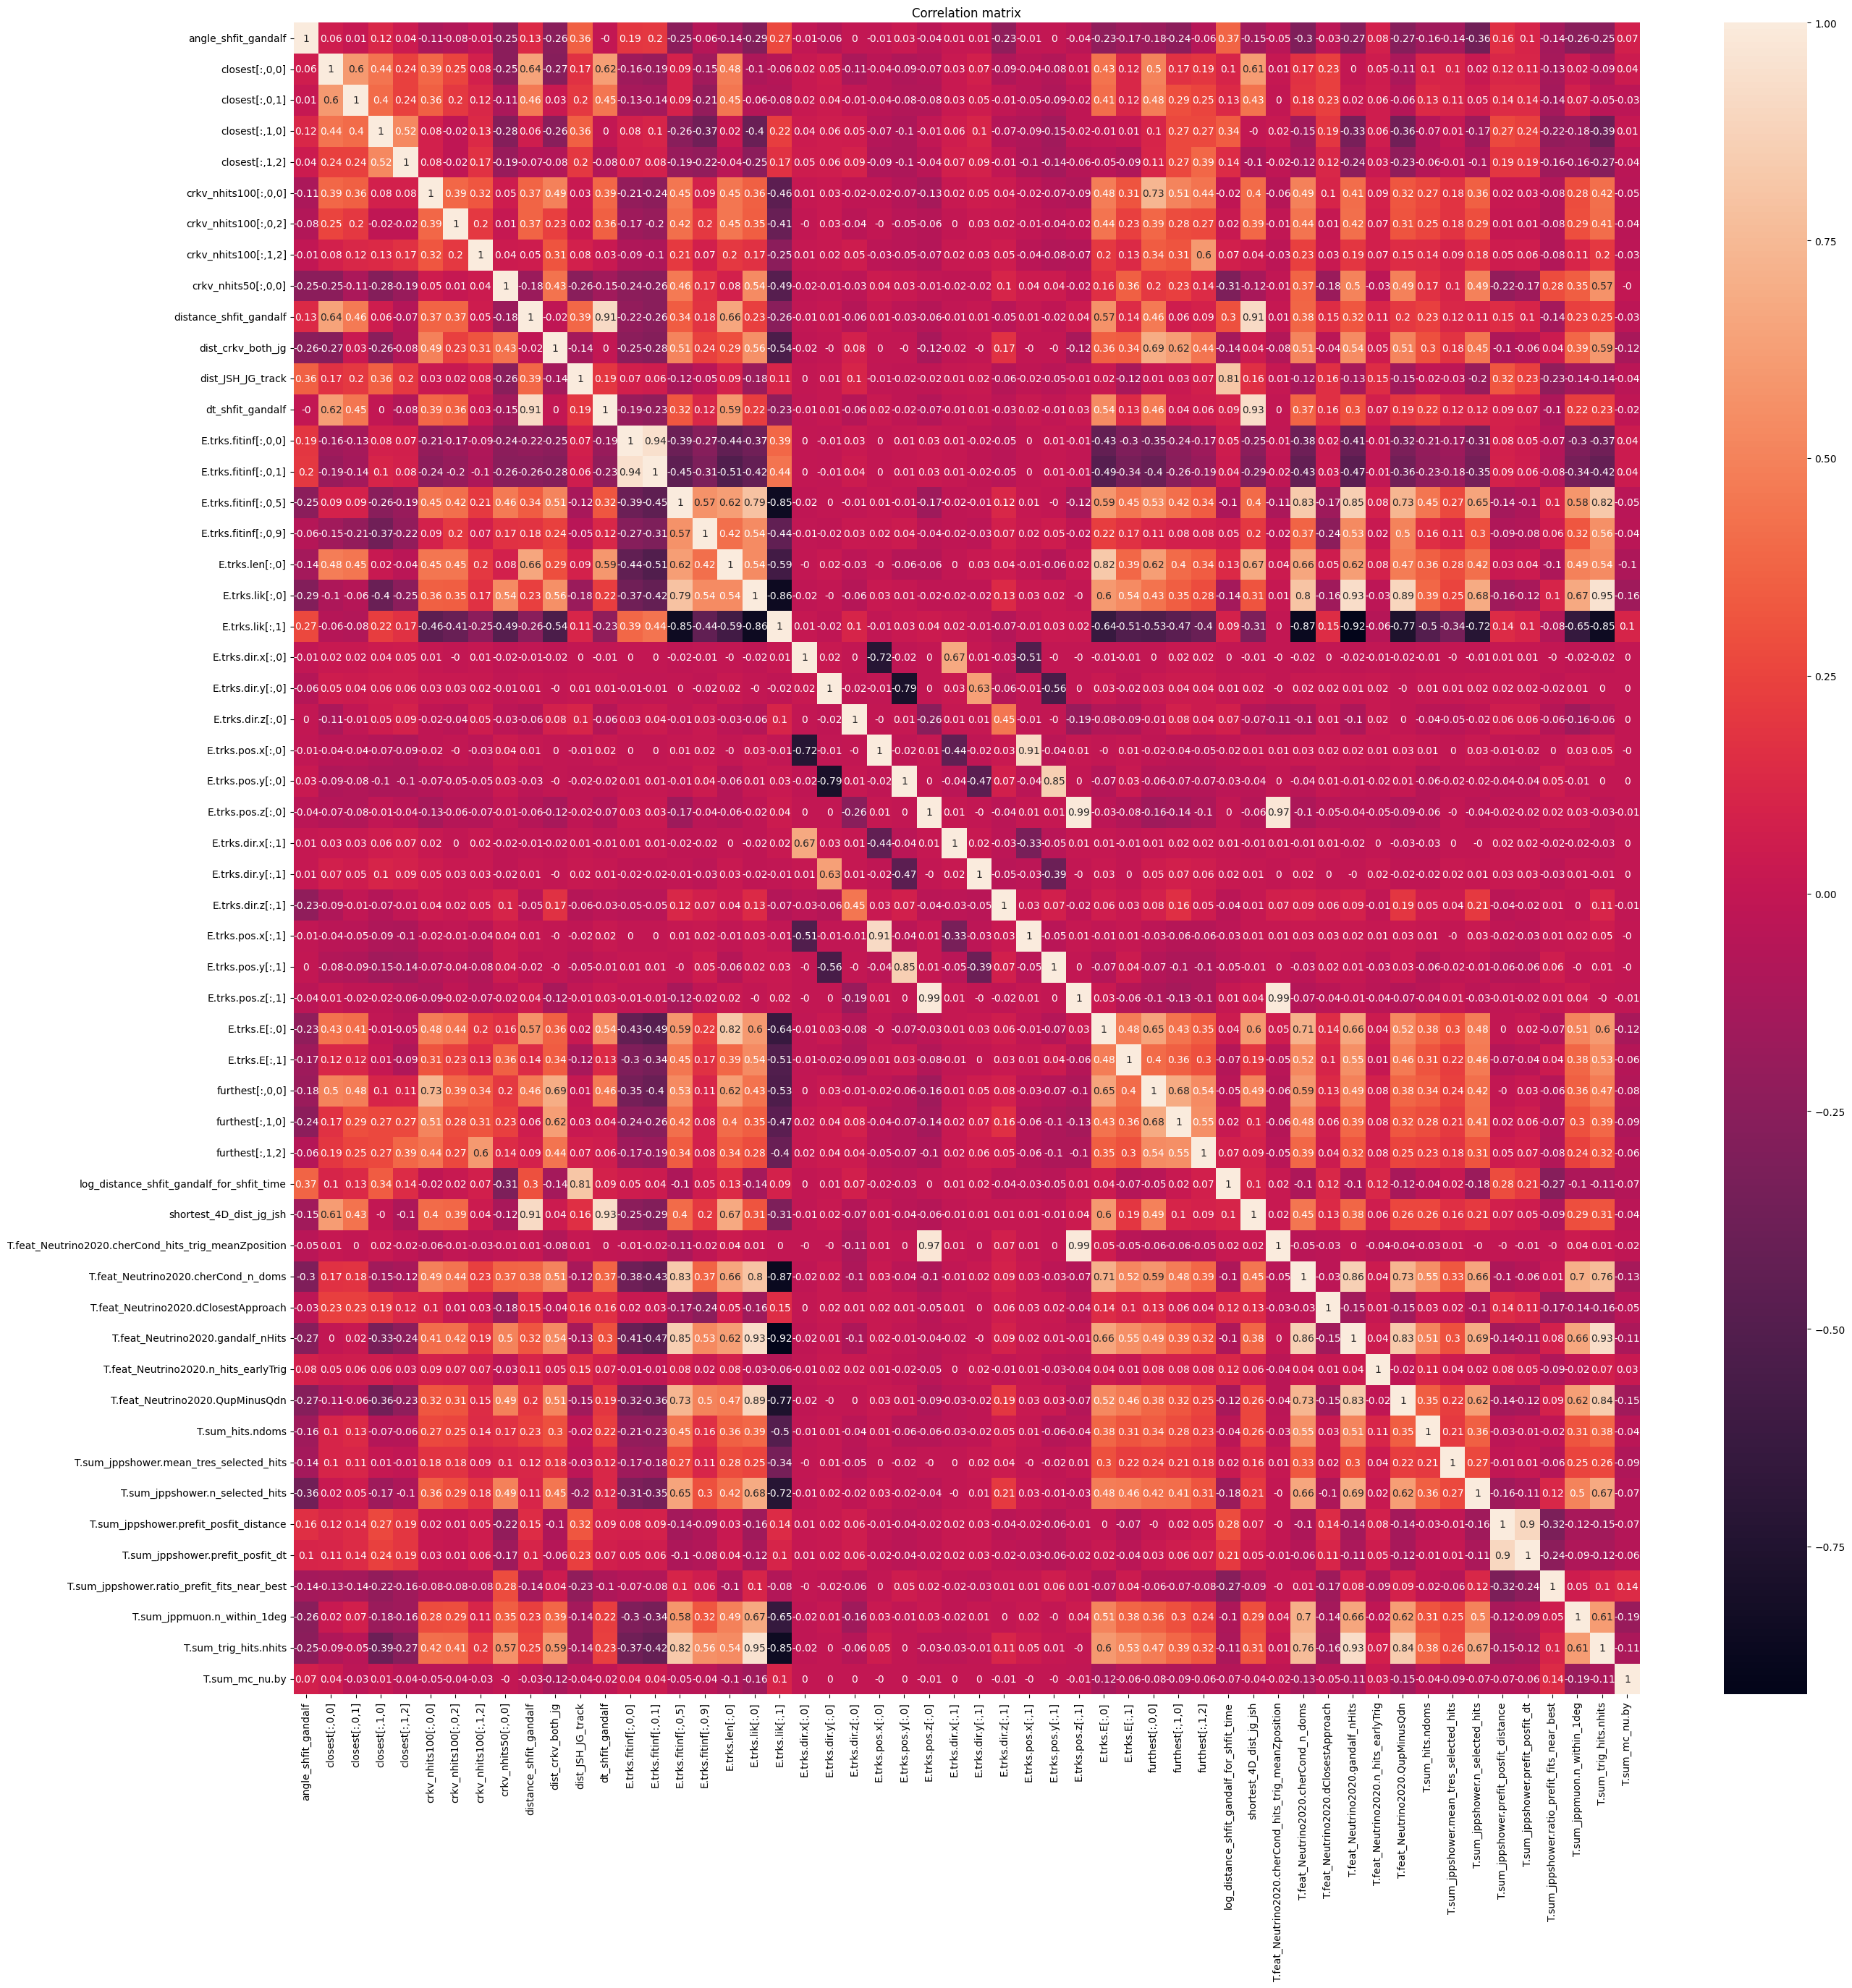

total correlation =  3.86
total squared correlations =  1.2734
60515


In [36]:
quantile_0 = 0.1
quantile_1 = 0.2
rel_threshold = 0
df_selec = df_test[(df_test["E.trks.lik[:,0]"]>np.quantile(df_test["E.trks.lik[:,0]"], quantile_0)) | (df_test["E.trks.lik[:,1]"] < np.quantile(df_test["E.trks.lik[:,1]"], 1-quantile_1))]

print(df_selec.info())
corr = correlation_matrix(df_selec, figsize = (30,30), plot = True)
# corr = df_selec.corr()
bjorkeny_corr = corr['T.sum_mc_nu.by']

print("total correlation = ", abs(bjorkeny_corr).sum())
print("total squared correlations = ", (bjorkeny_corr**2).sum())
# bjorkeny_corr = bjorkeny_corr[bjorkeny_corr!=0]
# bjorkeny_corr = bjorkeny_corr[b]
# bjorkeny_corr = bjorkeny_corr.sort_values(ascending = False)

non_rel = bjorkeny_corr.index[abs(bjorkeny_corr)<=rel_threshold]


print(len(df_selec))
X = df_selec.drop(columns = non_rel)
bjorkeny = X["T.sum_mc_nu.by"]
X = X.drop(columns = "T.sum_mc_nu.by")


# DNN

In [3]:
pdgid = 14
is_cc = 1
# likelihood = 0.2
nan_threshold = 0.2
# quantile_0 = 0.2
# quantile_1 = 0.4
loss_metric = "mae"



# Load data
df_11 = pd.read_hdf("datay/new_neutrino11x_1.h5")
df_12 = pd.read_hdf("datay/new_neutrino12x_1.h5")
df_13 = pd.read_hdf("datay/new_neutrino13x_1.h5")

df = pd.concat([df_11, df_12, df_13])

# with open("bjorkeny_study_2.pkl", "rb") as f:
#     study = pickle.load(f)

# best_params = study.best_params
# print(best_params)

# Remove nans and illegitimate values
df = remove_nans(df, nan_threshold)
df = df[np.invert((df['closest[:,0,0]']==1e20) | (df['closest[:,1,0]']==1e20) | (df['closest[:,1,2]']==1e20) | (df['closest[:,0,1]']==1e20)  )] 

# select the particle and interaction types
df = df[(df["pdgid"]==pdgid)&(df["is_cc"]==is_cc)]

# select based on energy
df = df[(df["E.trks.E[:,0]"]<=20) | (df["E.trks.E[:,1]"]<=20)]

# remove unneeded columns
df = df.drop(columns = ["exposure", "weight", "weight_rate", "E.run_id", "pdgid", "is_cc", "energy"])

# select based on likelihood

# q0 = np.quantile(df["E.trks.lik[:,0]"], quantile_0)
# q1 = np.quantile(df["E.trks.lik[:,1]"], 1-quantile_1)
# df = df[(df["E.trks.lik[:,0]"]>q0) | (df["E.trks.lik[:,1]"] < q1)]

# corr = df.corr()
# bjorkeny_corr = corr['T.sum_mc_nu.by']
# correlation_threshold = best_params["correlation_threshold"]
# non_rel = bjorkeny_corr.index[abs(bjorkeny_corr)<=correlation_threshold]

# df = df.drop(columns = non_rel)


bjorkeny = df["T.sum_mc_nu.by"].to_numpy()
X = df.drop(columns = "T.sum_mc_nu.by")
df_X = X.copy()

# Scale the data
scaler = preprocessing.RobustScaler()
X = scaler.fit_transform(X)

# # PCA
# n_components_PCA = best_params["n_components_PCA"]

# pca = PCA(n_components=n_components_PCA, svd_solver="full")
# X = pca.fit_transform(X)

# Split the data into folds
kfold = KFold(n_splits=5, shuffle=False)

n_layers = 20
n_nodes = 256
dropout_frac = 0.1
activation_hidden = 'relu'
activation_output = 'sigmoid'
learning_rate = 0.0001

scores = []

y_pred_total = []
y_test_total = []

for i , (train_index, test_index) in enumerate(kfold.split(X)):

    tf.keras.backend.clear_session()
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = bjorkeny[train_index], bjorkeny[test_index]

    # Train the DNN
    DNN = tf.keras.Sequential()
    DNN.add(tf.keras.layers.Input(shape=(X.shape[1],)))
    # DNN.add(tf.keras.layers.Dense(64, activation="relu"))

    if n_layers ==1:
        DNN.add(tf.keras.layers.Dense(n_nodes, activation=activation_hidden))
        DNN.add(keras.layers.Dropout(dropout_frac))
    else: 
        for _ in range(n_layers-1):
            DNN.add(tf.keras.layers.Dense(n_nodes, activation=activation_hidden))
            DNN.add(keras.layers.Dropout(dropout_frac))

        DNN.add(tf.keras.layers.Dense(int(0.5*n_nodes), activation=activation_hidden))

        DNN.add(keras.layers.Dropout(dropout_frac))

    DNN.add(tf.keras.layers.Dense(1, activation=activation_output))
    DNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")

    DNN.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), callbacks=[callback], verbose = 0)
    score = DNN.evaluate(X_test, y_test, verbose=0)
    y_pred = DNN.predict(X_test)
    y_pred_total.extend(y_pred)
    y_test_total.extend(y_test)
    scores.append(score)

keras.backend.clear_session()
print(np.mean(scores))

y_pred_total = np.array(y_pred_total).reshape(-1,1)
y_test_total = np.array(y_test_total).reshape(-1,1)

2024-06-16 22:26:09.725334: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-16 22:26:09.726290: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
0.20067152082920076


In [ ]:
y_pred_total = np.ravel(y_pred_total)
y_test_total = np.ravel(y_test_total)



0.20067152082920076 0.001562800192834487
(137253, 1)
(137253, 1)


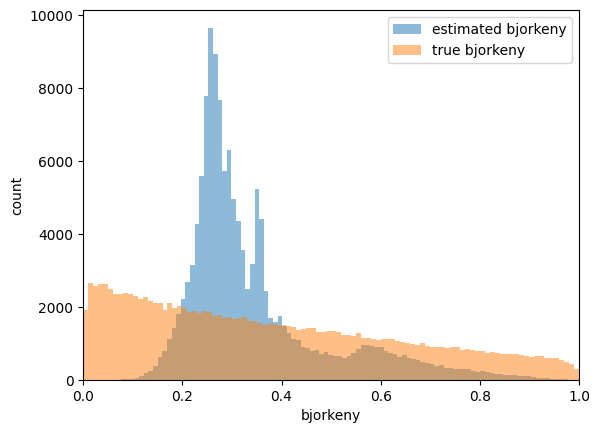

/tmp/ipykernel_1315/3820185998.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


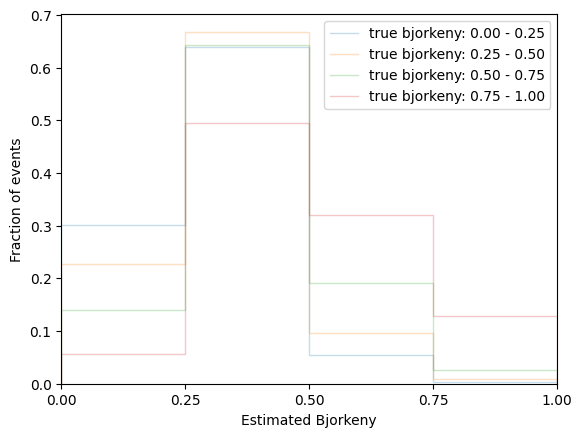

In [4]:
print(np.mean(scores), np.std(scores))
# print((y_pred_total))
# y_pred_total = np.ravel(y_pred_total)
print(np.shape(y_pred_total))
print(np.shape(y_test_total))
plt.hist(y_pred_total, bins = 100, alpha = 0.5, label = "estimated bjorkeny")
plt.hist(y_test_total, bins = 100, alpha = 0.5, label = "true bjorkeny")
plt.xlabel("bjorkeny")
plt.ylabel("count")
plt.xlim(0,1)
plt.legend()
plt.show()

x_axis = np.linspace(0,1,5)

true_bjorkeny_1_mask = y_test_total <= 0.25
est_bjorkeny_1_mask = y_pred_total <= 0.25

true_bjorkeny_2_mask = (y_test_total <= 0.5) & (y_test_total > 0.25)
est_bjorkeny_2_mask = (y_pred_total <= 0.5) & (y_pred_total > 0.25)

true_bjorkeny_3_mask = (y_test_total <= 0.75) & (y_test_total > 0.5)
est_bjorkeny_3_mask = (y_pred_total <= 0.75) & (y_pred_total > 0.5)

true_bjorkeny_4_mask = (y_test_total <= 1) & (y_test_total > 0.75)
est_bjorkeny_4_mask = (y_pred_total <= 1) & (y_pred_total > 0.75)

true_segments = [true_bjorkeny_1_mask, true_bjorkeny_2_mask, true_bjorkeny_3_mask, true_bjorkeny_4_mask]
est_segments = [est_bjorkeny_1_mask, est_bjorkeny_2_mask, est_bjorkeny_3_mask, est_bjorkeny_4_mask]

fig, ax = plt.subplots()
for i, segment in enumerate(true_segments):
    frac = np.sum(segment&est_segments[i])/np.sum(segment)
    fractions = [(np.sum(segment & est_segment))/np.sum(segment) for est_segment in est_segments]
    ax.stairs(fractions, x_axis, alpha = 0.25, fill = False, label = f"true bjorkeny: {x_axis[i]:.2f} - {x_axis[i+1]:.2f}")

ax.set_xticks(x_axis)
ax.legend()
ax.set_xlim(0,1)
ax.set_xlabel("Estimated Bjorkeny")
ax.set_ylabel("Fraction of events")
fig.show()

# plt.scatter(y_test, est_bjorkeny)
# plt.xlabel("True Bjorkeny")
# plt.ylabel("Estimated Bjorkeny")
# plt.show()

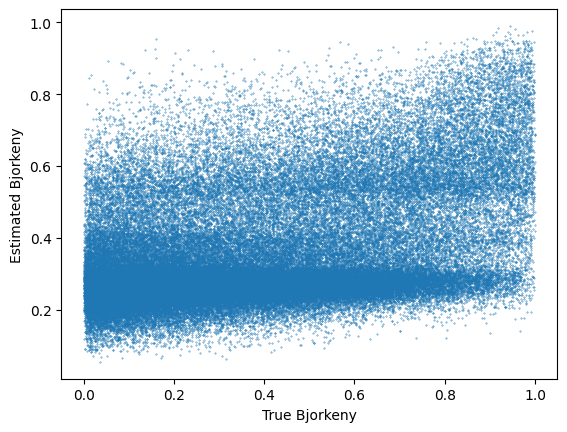

In [12]:
plt.scatter(y_test_total, y_pred_total, s=0.1)
plt.xlabel("True Bjorkeny")
plt.ylabel("Estimated Bjorkeny")
plt.show()

## analyze the two different distributions in the data

length of test data is  111991
the corresponding is  111991


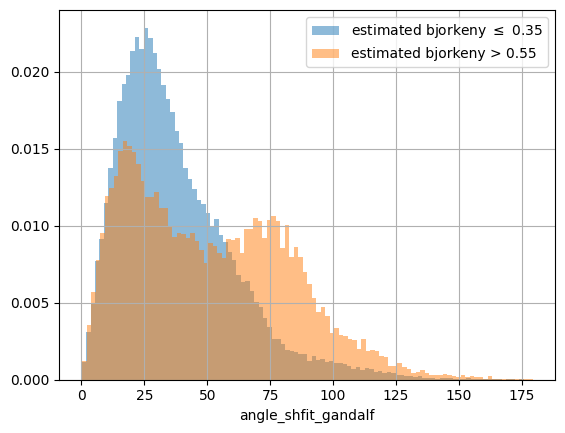

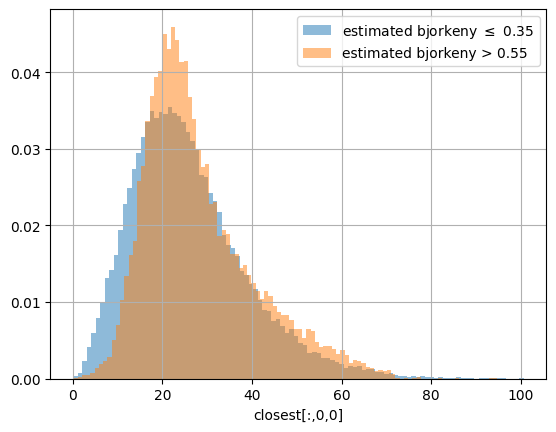

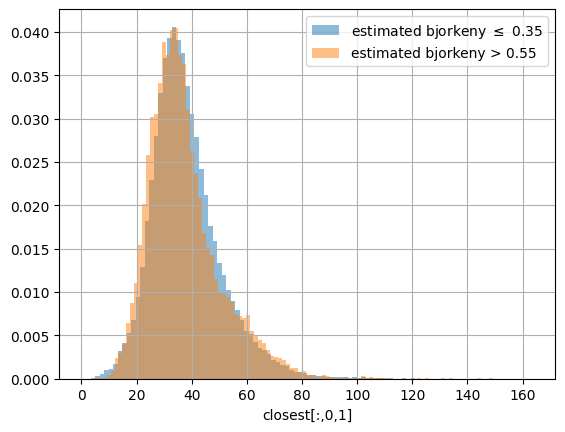

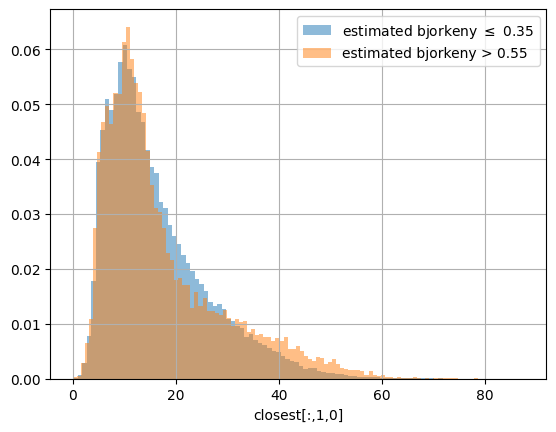

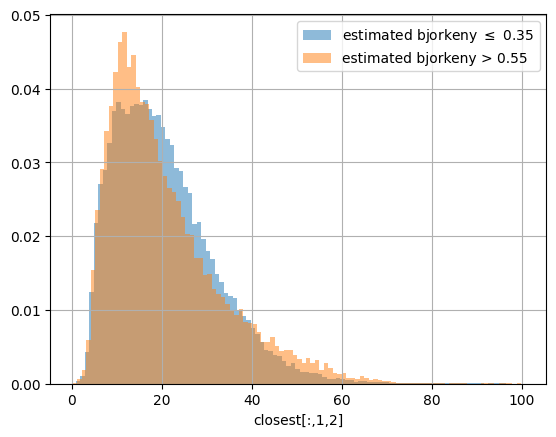

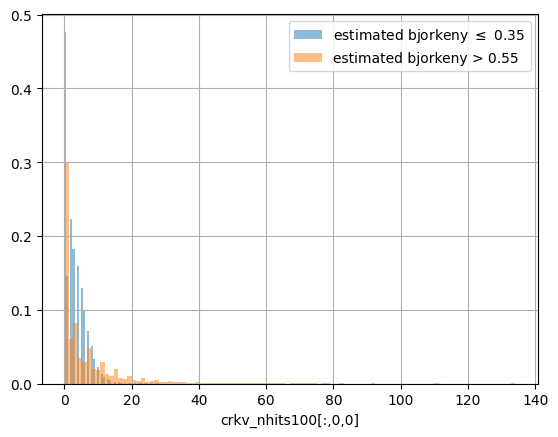

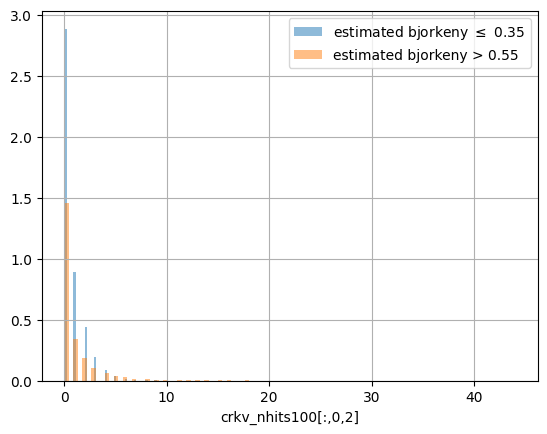

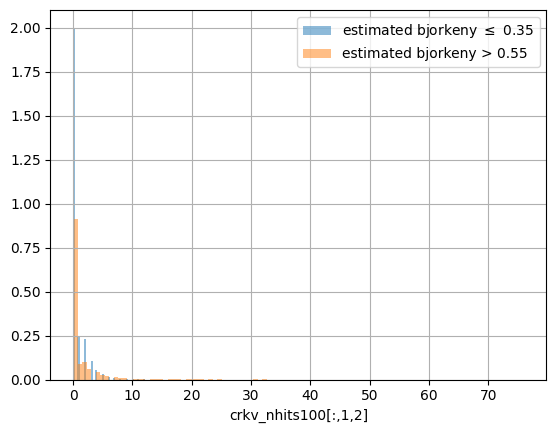

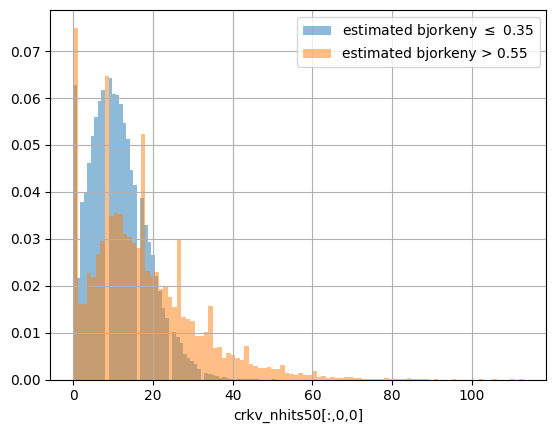

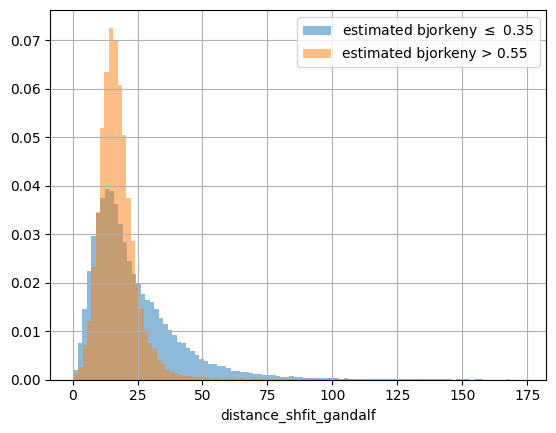

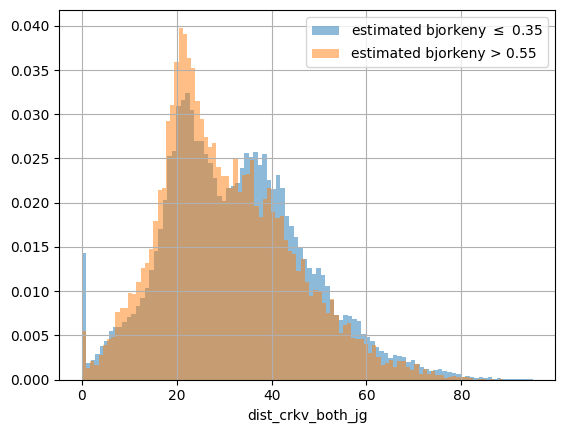

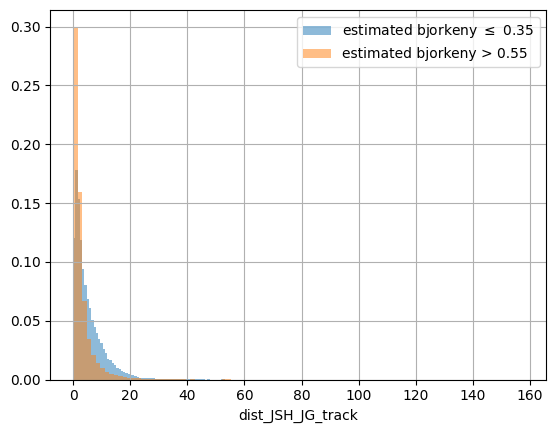

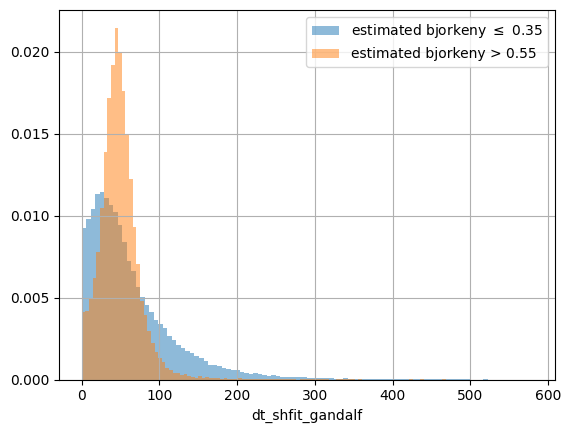

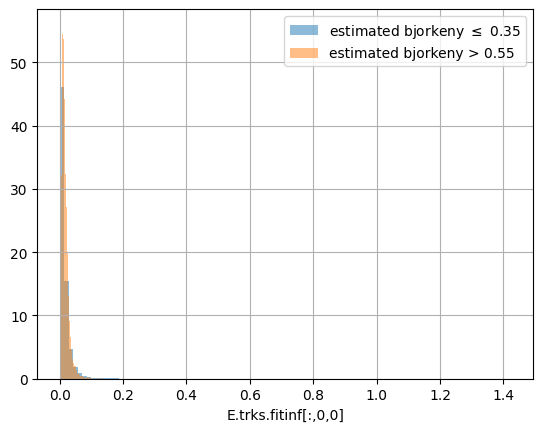

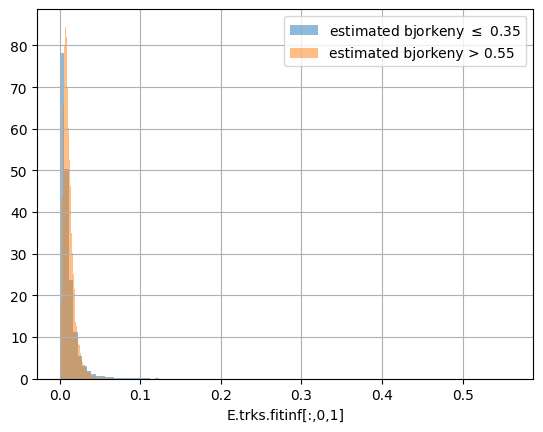

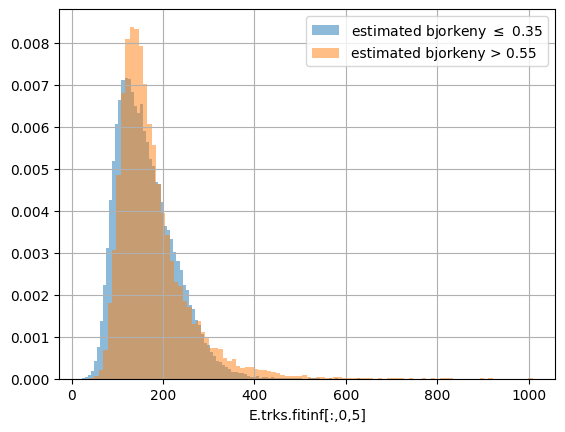

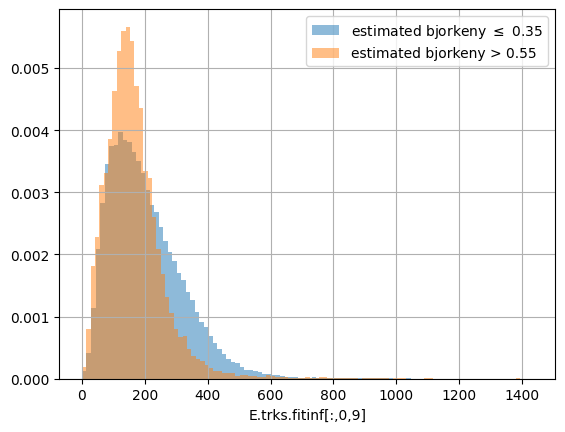

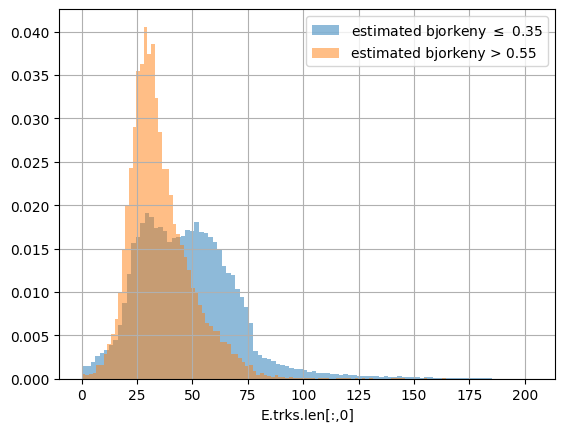

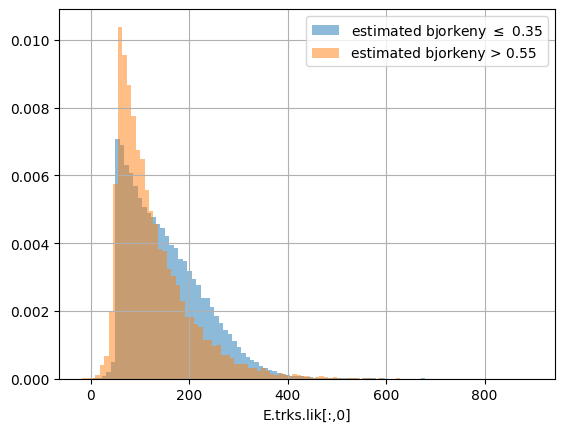

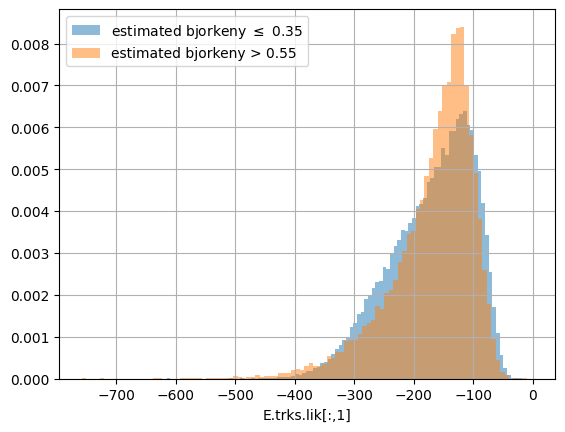

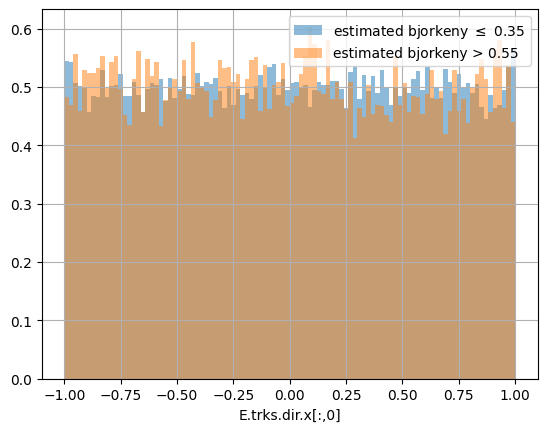

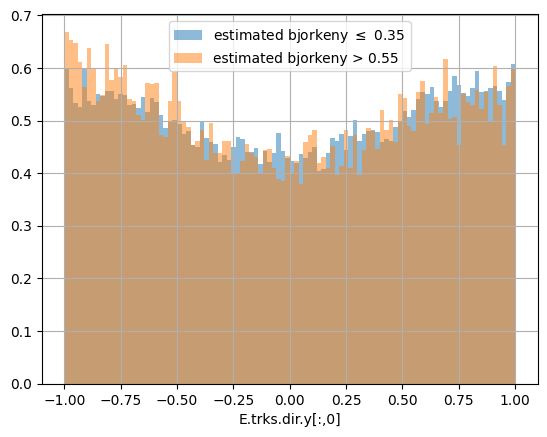

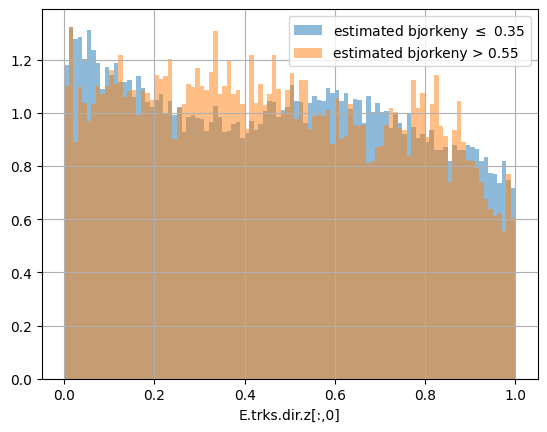

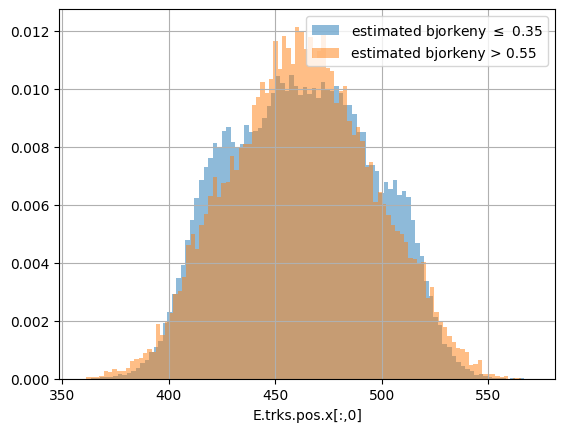

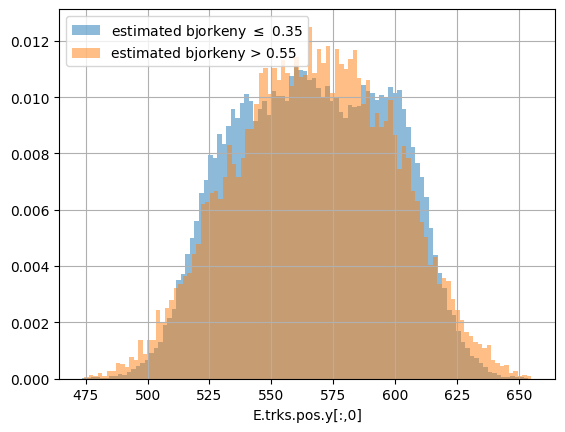

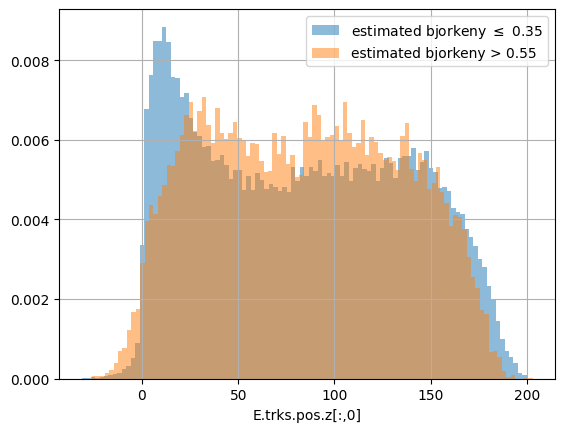

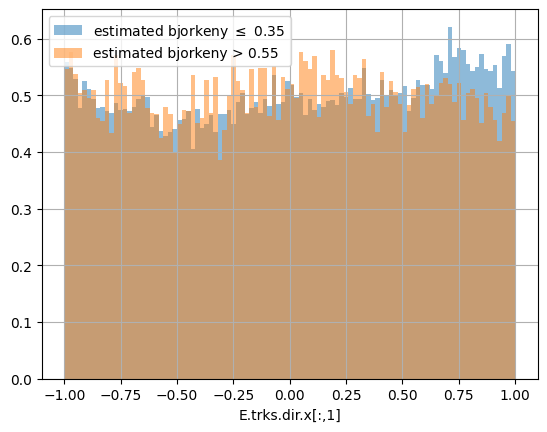

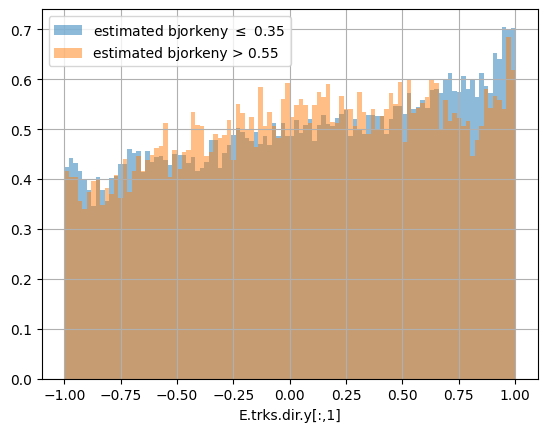

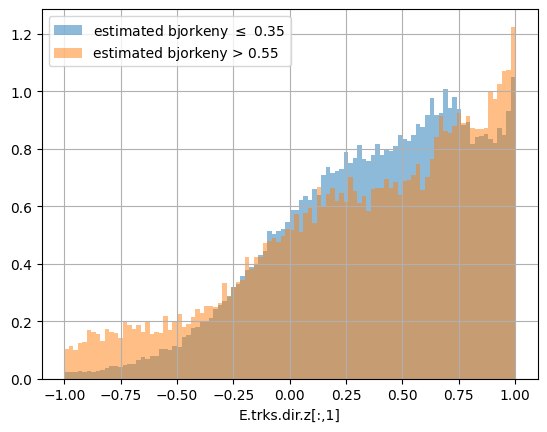

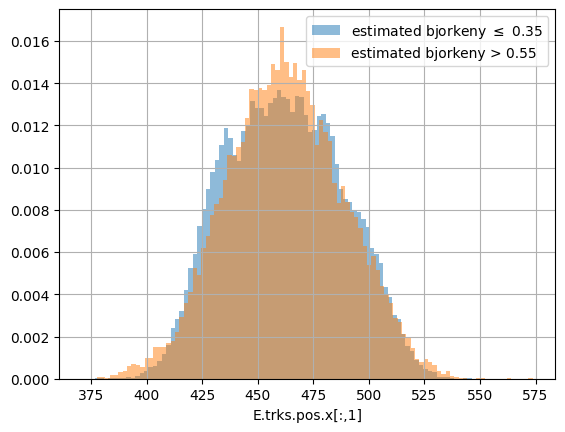

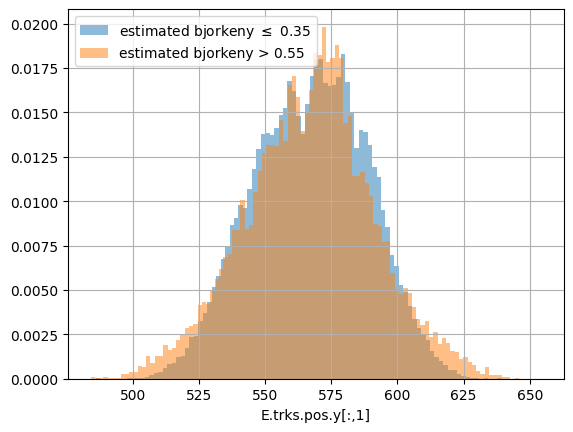

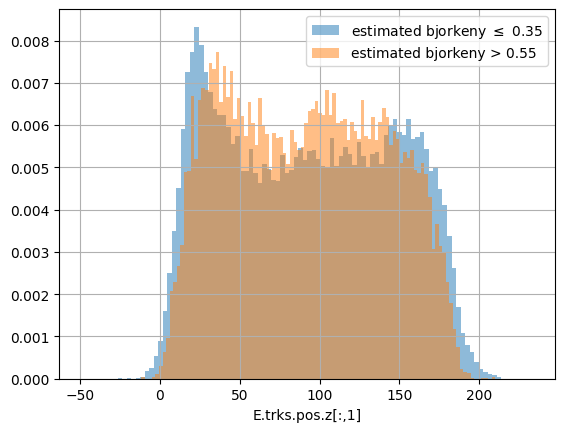

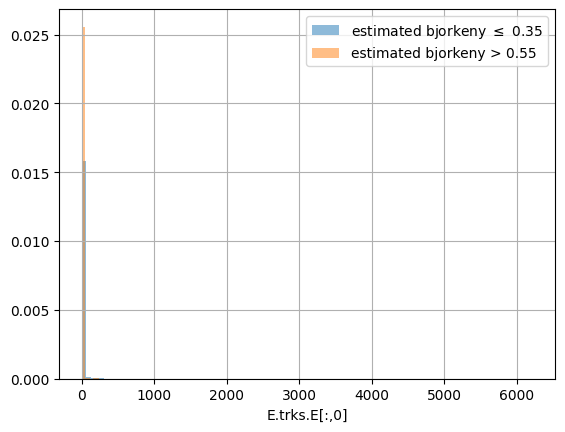

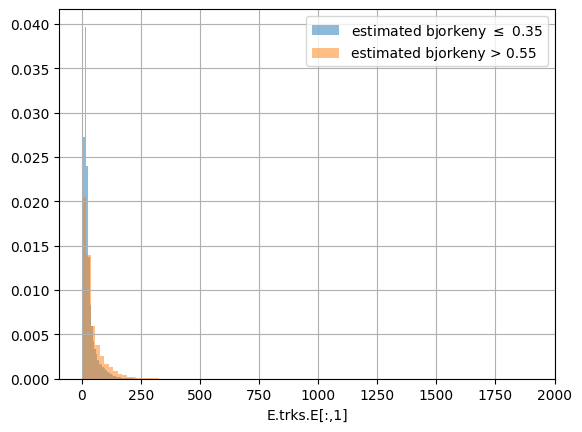

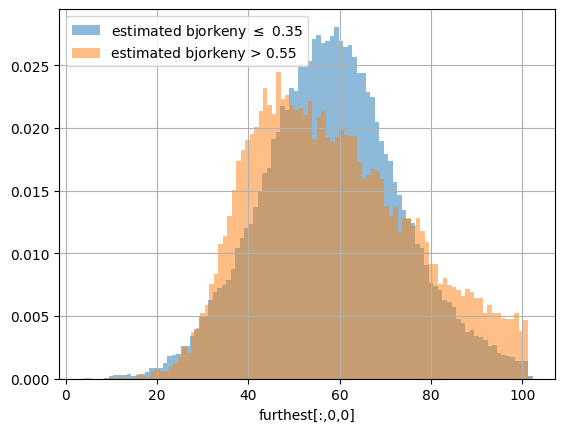

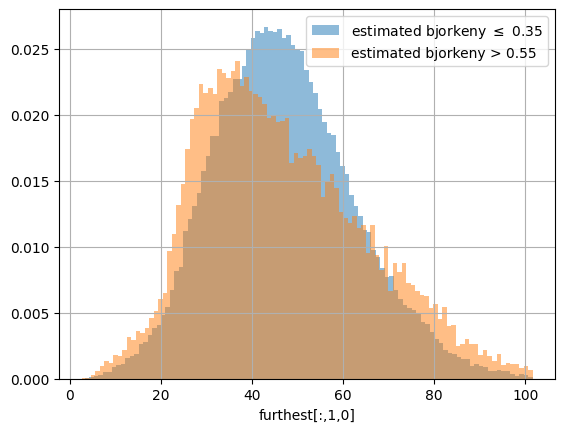

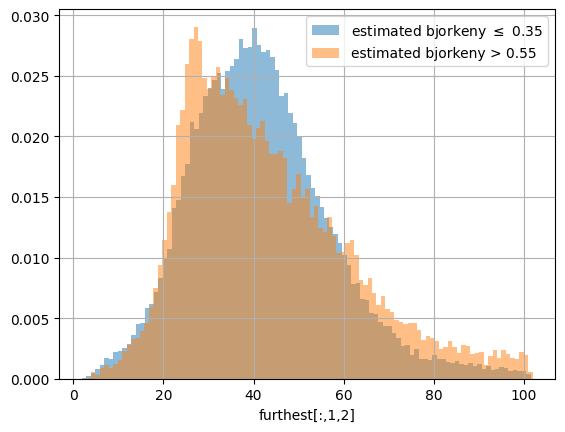

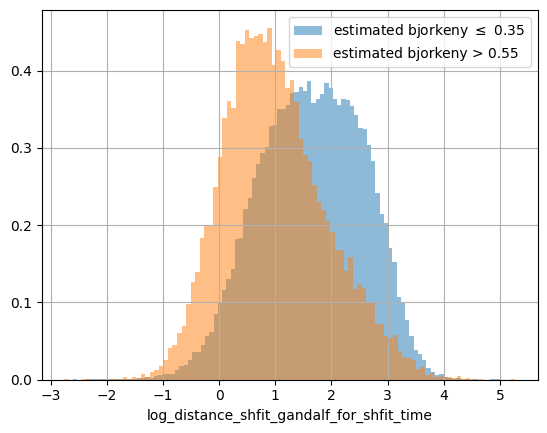

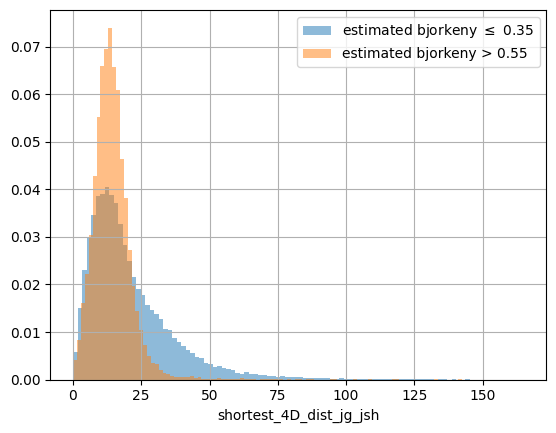

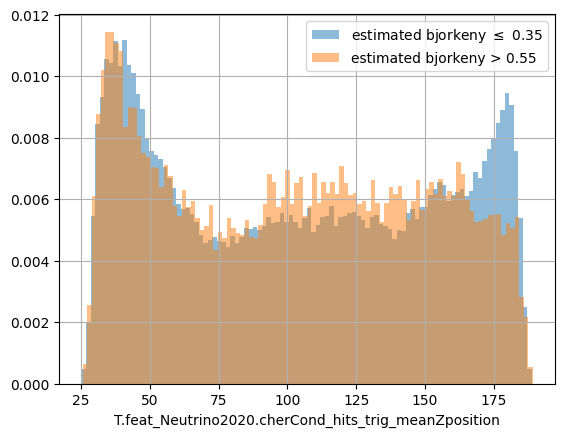

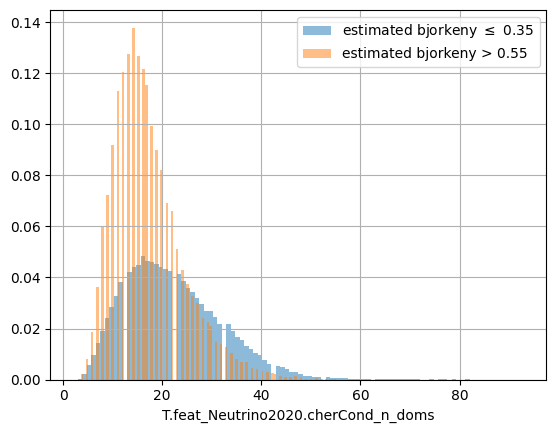

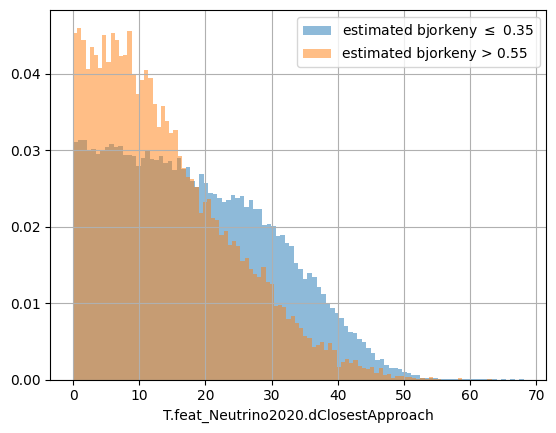

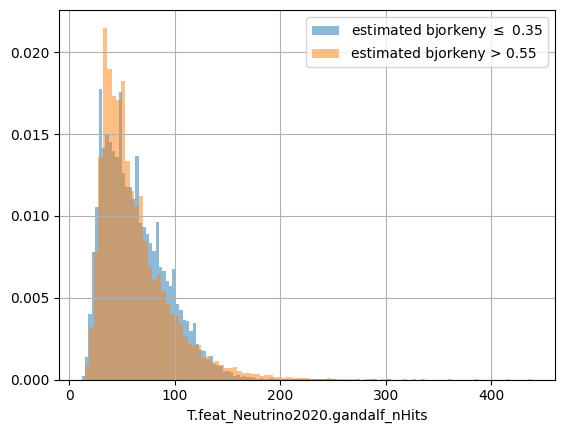

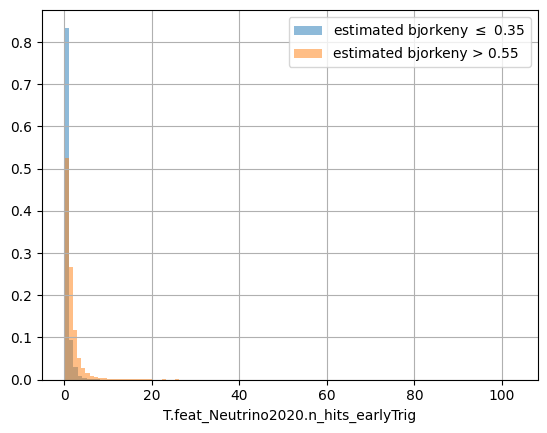

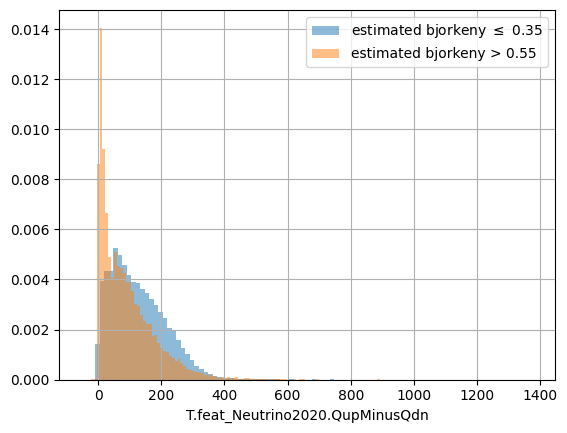

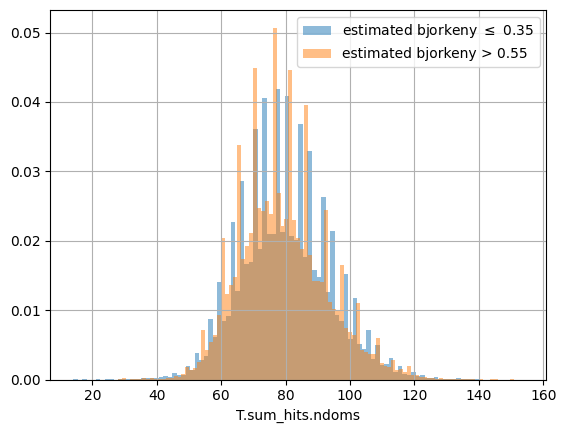

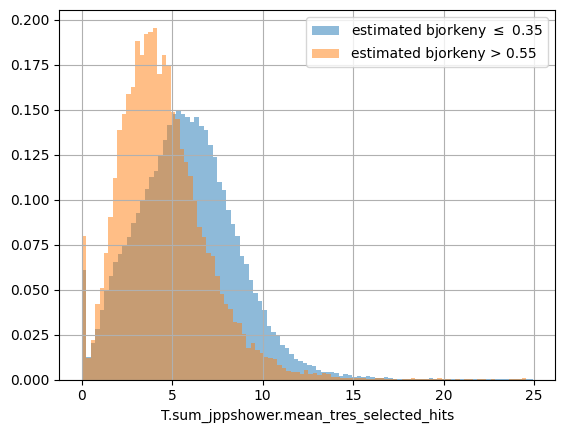

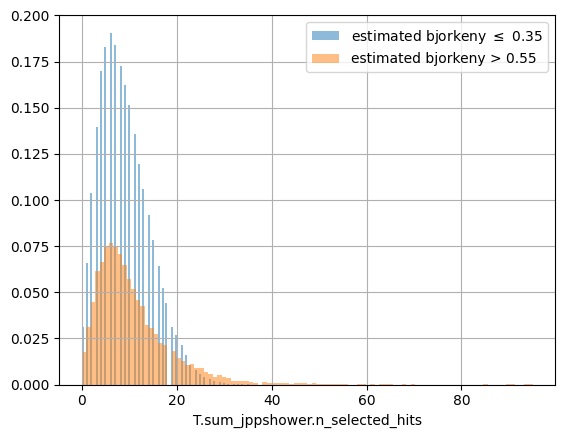

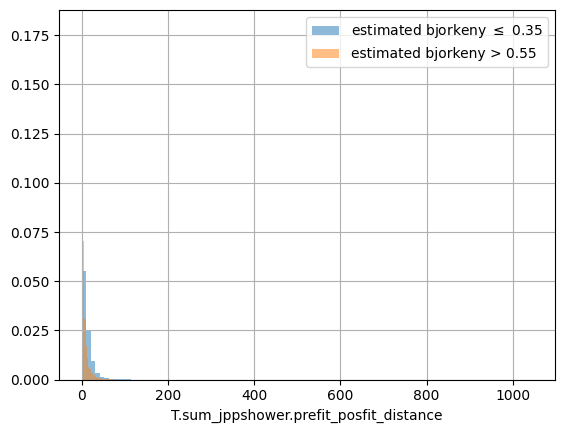

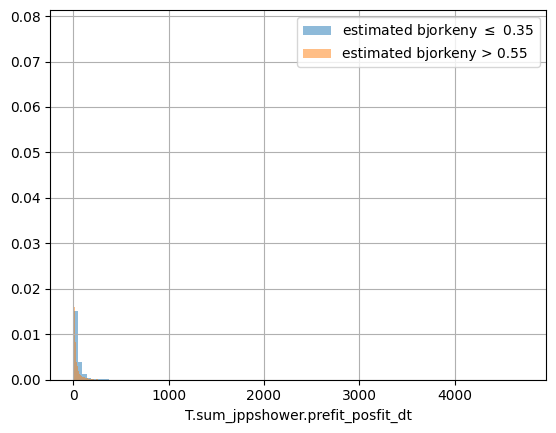

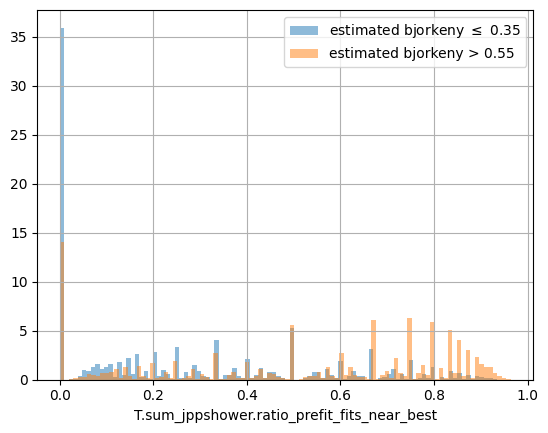

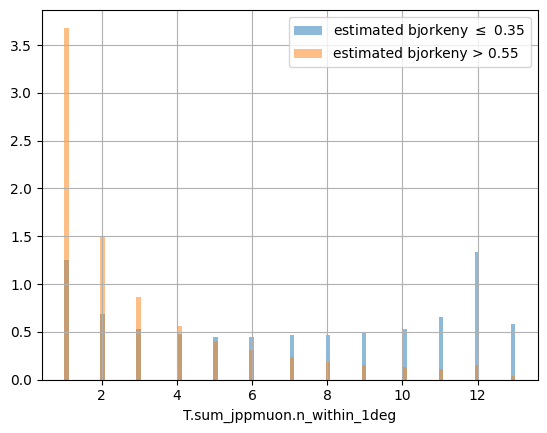

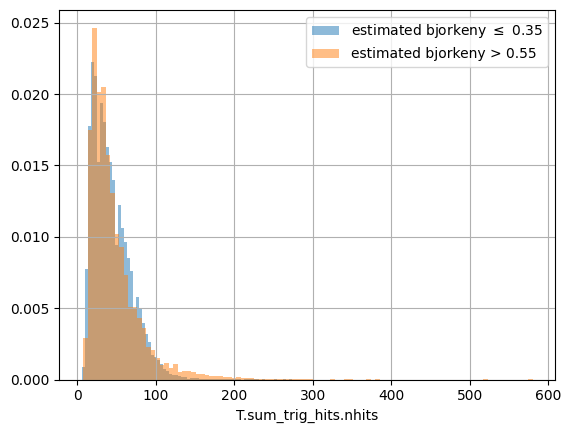

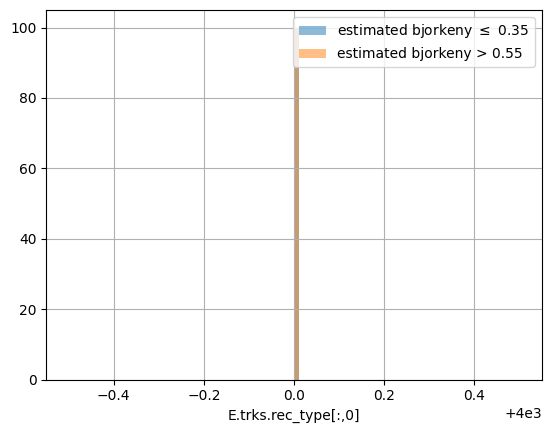

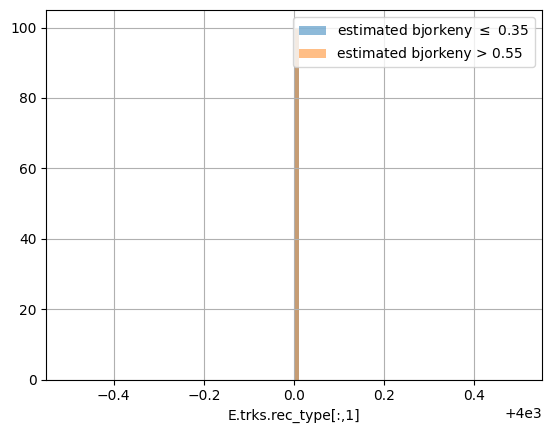

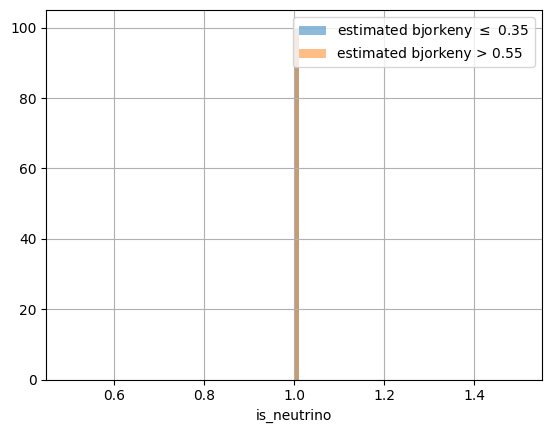

In [14]:
# first check if the data indexing matches
print("length of test data is ", len(y_test_total))
print("the corresponding is ", np.sum(y_test_total == bjorkeny))

X_dist_1 = df_X[y_pred_total <= 0.35]
X_dist_2 = df_X[y_pred_total > 0.50]

for column in df_X.columns:
    hist_1 = X_dist_1[column].hist(bins = 100, alpha = 0.5, label = "estimated bjorkeny $\leq$ 0.35", density = True)
    hist_2 = X_dist_2[column].hist(bins = 100, alpha = 0.5, label = "estimated bjorkeny > 0.55", density = True)
    plt.xlabel(column)
    plt.legend()
    plt.show()

# Try RDF regression

In [15]:
X = df.drop(columns = ["exposure", "weight", "weight_rate", "E.run_id", "pdgid", "is_cc", "energy", "T.sum_mc_nu.by"])
y = df["T.sum_mc_nu.by"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, bjorkeny , shuffle = True, test_size=0.2, random_state=42)

In [9]:
n_estimators = 101
regr = RFR(n_estimators=n_estimators, random_state=42, n_jobs=-1, verbose = 1)
regr.fit(X_train, y_train)
y_pred_total = regr.predict(X_test)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   33.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.5s finished


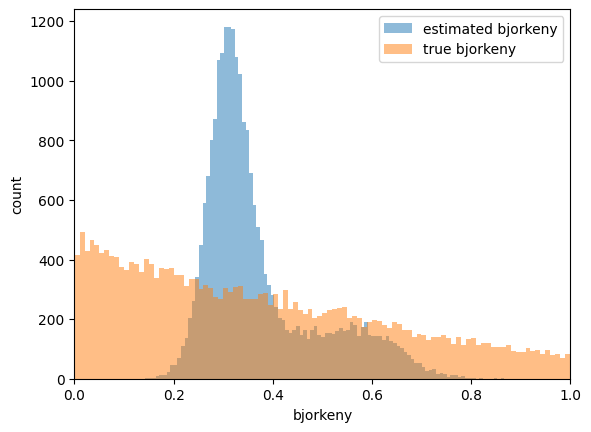

/tmp/ipykernel_906/202839158.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


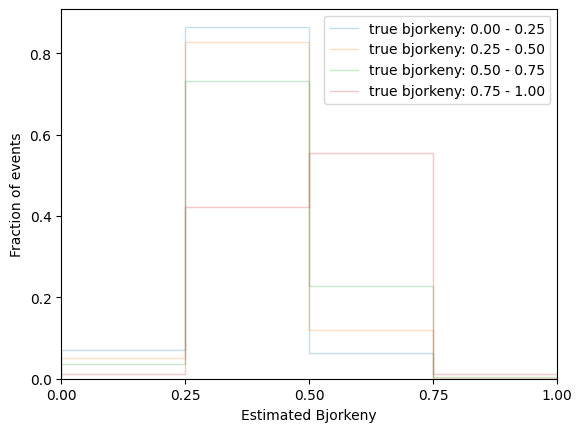

In [10]:
plt.hist(y_pred_total, bins = 100, alpha = 0.5, label = "estimated bjorkeny")
plt.hist(y_test, bins = 100, alpha = 0.5, label = "true bjorkeny")
plt.xlabel("bjorkeny")
plt.ylabel("count")
plt.xlim(0,1)
plt.legend()
plt.show()

x_axis = np.linspace(0,1,5)

true_bjorkeny_1_mask = y_test <= 0.25
est_bjorkeny_1_mask = y_pred_total <= 0.25

true_bjorkeny_2_mask = (y_test <= 0.5) & (y_test > 0.25)
est_bjorkeny_2_mask = (y_pred_total <= 0.5) & (y_pred_total > 0.25)

true_bjorkeny_3_mask = (y_test <= 0.75) & (y_test > 0.5)
est_bjorkeny_3_mask = (y_pred_total <= 0.75) & (y_pred_total > 0.5)

true_bjorkeny_4_mask = (y_test <= 1) & (y_test > 0.75)
est_bjorkeny_4_mask = (y_pred_total <= 1) & (y_pred_total > 0.75)

true_segments = [true_bjorkeny_1_mask, true_bjorkeny_2_mask, true_bjorkeny_3_mask, true_bjorkeny_4_mask]
est_segments = [est_bjorkeny_1_mask, est_bjorkeny_2_mask, est_bjorkeny_3_mask, est_bjorkeny_4_mask]

fig, ax = plt.subplots()
for i, segment in enumerate(true_segments):
    frac = np.sum(segment&est_segments[i])/np.sum(segment)
    fractions = [(np.sum(segment & est_segment))/np.sum(segment) for est_segment in est_segments]
    ax.stairs(fractions, x_axis, alpha = 0.25, fill = False, label = f"true bjorkeny: {x_axis[i]:.2f} - {x_axis[i+1]:.2f}")

ax.set_xticks(x_axis)
ax.legend()
ax.set_xlim(0,1)
ax.set_xlabel("Estimated Bjorkeny")
ax.set_ylabel("Fraction of events")
fig.show()

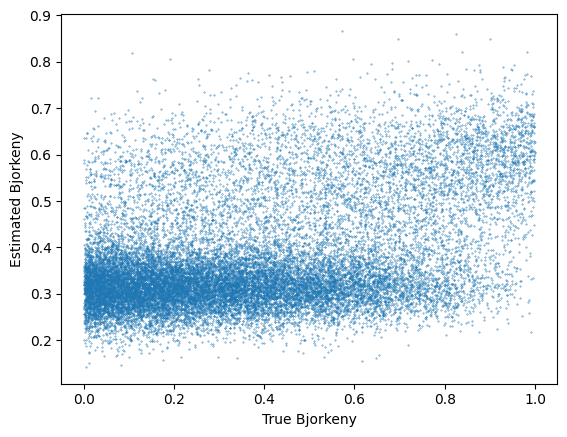

In [11]:
plt.scatter(y_test, y_pred_total, s=0.1)
plt.xlabel("True Bjorkeny")
plt.ylabel("Estimated Bjorkeny")
plt.show()

# Try RDF classification into the 4 categories

In [12]:
y=bjorkeny
first = y <= 0.25
second = (y > 0.25) & (y <= 0.5)
third = (y > 0.5) & (y <= 0.75)
fourth = y > 0.75

y_labels = y.copy()
y_labels[first] = 0
y_labels[second] = 1
y_labels[third] = 2
y_labels[fourth] = 3


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels , shuffle = True, test_size=0.2, random_state=42)

In [14]:
n_estimators = 101
regr = RFC(n_estimators=n_estimators, random_state=42, n_jobs=-1, verbose = 1, class_weight='balanced')
regr.fit(X_train, y_train)
y_pred_total = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    8.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.3s finished


In [15]:
print(regr.score(X_test, y_test))


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


0.432297400287916


[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:    0.3s finished


In [16]:
for segment in range(4):
    print(f"segment {segment}")
    estimates = y_pred_total[y_test == segment]
    counter = Counter(estimates)
    perc = {key: value/len(estimates) for key, value in counter.items()}
    print(perc)



segment 0
{0.0: 0.8373723832113025, 1.0: 0.09704032174899453, 2.0: 0.03196865009796845, 3.0: 0.033618644941734555}
segment 1
{0.0: 0.7759595358524248, 3.0: 0.06962213626896757, 2.0: 0.05534067241892294, 1.0: 0.09907765545968462}
segment 2
{0.0: 0.6513961605584643, 1.0: 0.11387434554973822, 3.0: 0.13721640488656195, 2.0: 0.0975130890052356}
segment 3
{0.0: 0.3403441682600382, 1.0: 0.10975143403441683, 3.0: 0.37361376673040153, 2.0: 0.17629063097514341}


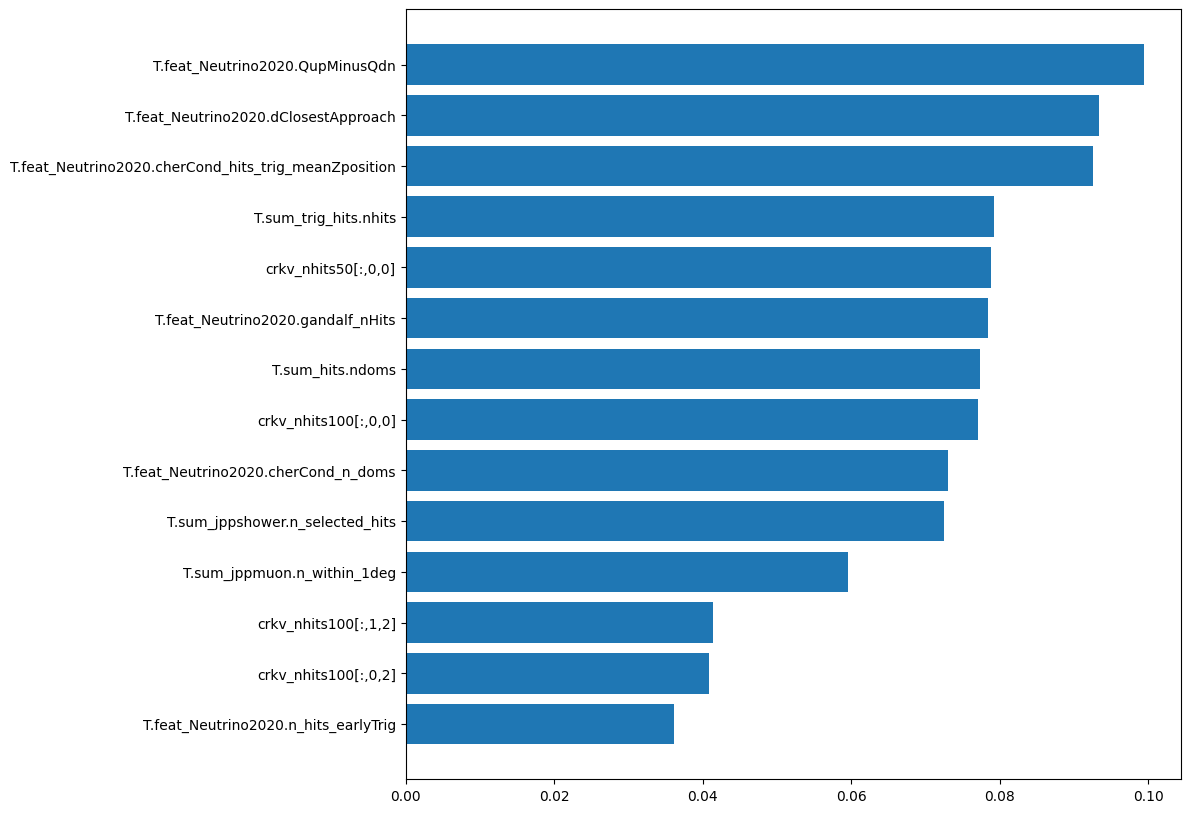

<class 'pandas.core.frame.DataFrame'>
Index: 118088 entries, 1098 to 235605
Data columns (total 14 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   crkv_nhits100[:,0,0]                                  118088 non-null  int32  
 1   crkv_nhits100[:,0,2]                                  118088 non-null  int32  
 2   crkv_nhits100[:,1,2]                                  118088 non-null  int32  
 3   crkv_nhits50[:,0,0]                                   118088 non-null  int32  
 4   T.feat_Neutrino2020.cherCond_hits_trig_meanZposition  118088 non-null  float32
 5   T.feat_Neutrino2020.cherCond_n_doms                   118088 non-null  int32  
 6   T.feat_Neutrino2020.dClosestApproach                  118088 non-null  float32
 7   T.feat_Neutrino2020.gandalf_nHits                     118088 non-null  int32  
 8   T.feat_Neutrino2020.n_hits_earlyTrig          

In [17]:
feature_importances = regr.feature_importances_
n_its = 1
plt.figure(figsize=(10,10))
f_i = list(zip(X_train.columns , feature_importances/n_its))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

print(X.info())